In [184]:
import os
import pandas as pd
import numpy as np
import PIconnect as PI
from PIconnect.PIConsts import AuthenticationMode
from PIconnect.PIConsts import RetrievalMode
from math import exp, log, pi
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
# sns.set(color_codes=True)
import matplotlib.pyplot as plt
import sympy as sp
from sympy import Symbol
from scipy.optimize import fsolve

from numpy.random import seed
import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [358]:
## Helper functions ##

# Retrieve data from the PI db for selected timeframes, columns, and frequency
def retrieve_data(start_time, end_time, all_data=False, columns = [], frequency = '1s'):
    """
    Function to retrieve data from Aveva PI
        :return: dataframe: dataframe of data from Aveva PI for a selected timeframe.
    """
    df = pd.DataFrame()

    with PI.PIServer(server = '172.16.2.6', username = 'ssteeley', password = 'PIVision1', authentication_mode=AuthenticationMode.WINDOWS_AUTHENTICATION) as server:
        with PI.PIAFDatabase() as database:

            # No specific columns selected in the form
            if len(columns) == 0:
                if all_data: # Pull data from all columns over the given timeframe, not just the ones being used
                    kids = database.children['Core Tester Machine'].children
                else: # Pull the data from only the columns that are being used
                    kids = {k:v for k,v in database.children['Core Tester Machine'].children.items() if k in ['AI12','AI48','AI66','DPT45','Loaded Test Parameters','Process Gas','PT42','TIC11','TT52']}
                bFirstPass = True
                for key in kids.keys():
                    if all_data:
                        children = kids[key].attributes
                    else:
                        children = [c for c in kids[key].attributes if c in ['Moisture','Dewpoint','CO2','CO2 Feedback Filtered Comp1','Pressure Feedback','Velocity Setpoint','Test Selected','Dewpoint Setpoint','N2 LF Feedback','N2 HF Feedback','N2 Tank Flow Feedback','CO2 Tank Flow Feedback','Feedback','Temperature Feedback','Test Iteration']]
                    for child in children:
                        data = (kids[key].attributes[child].interpolated_values(str(start_time), str(end_time), frequency))
                        df_n = data.to_frame().reset_index()
                        df_n.columns.values[1] = (f'{kids[key].name}_{kids[key].attributes[child].name}')
                        if bFirstPass:                
                            df_n= df_n.iloc[:,:]    
                            bFirstPass = False
                        else:
                            df_n= df_n.iloc[:,[1]]
                        df = pd.concat([df, df_n], axis = 1)
                kids_2 = database.children['Core Tester Machine'].children['TK001'].children
                for key in kids_2.keys():
                    if all_data:
                        children = kids_2[key].attributes
                    else:
                        children = [c for c in kids_2[key].attributes if c in ['Feedback']]
                    for child in children:
                        data = (kids_2[key].attributes[child].interpolated_values(str(start_time), str(end_time), frequency))
                        df_n = data.to_frame().reset_index()
                        df_n.columns.values[1] = (f'{kids_2[key].name}_{kids_2[key].attributes[child].name}')
                        df_n= df_n.iloc[:,[1]]
                        df = pd.concat([df, df_n], axis = 1)
                element = database.children['Core Tester Machine']
                if all_data:
                    attributes = element.attributes
                else:
                    attributes = [a for a in element.attributes if a in ['DO SV35','DO SV31','CMD SV18','CMD SV17','System State']]
                for attr in attributes:
                    data = (element.attributes[attr].interpolated_values(str(start_time), str(end_time), frequency))
                    df_n = data.to_frame().reset_index()
                    df_n= df_n.iloc[:,[1]]
                    df = pd.concat([df, df_n], axis = 1)

            # Specific columns selected
            else:
                tup_cols = [tuple(i.split(',')) for i in columns]
                bFirstPass = True
                for tc in tup_cols:
                    if len(tc) == 1:
                        element = database.children['Core Tester Machine']
                        data = (element.attributes[tc[0]].interpolated_values(str(start_time), str(end_time), frequency))
                        df_n = data.to_frame().reset_index()
                        
                    elif len(tc) == 2:
                        kids = database.children['Core Tester Machine'].children
                        data = (kids[tc[0]].attributes[tc[1]].interpolated_values(str(start_time), str(end_time), frequency))
                        df_n = data.to_frame().reset_index()
                        df_n.columns.values[1] = (f'{kids[tc[0]].name}_{kids[tc[0]].attributes[tc[1]].name}')
                        
                    elif len(tc) == 3:
                        kids_2 = database.children['Core Tester Machine'].children[tc[0]].children
                        data = (kids_2[tc[1]].attributes[tc[2]].interpolated_values(str(start_time), str(end_time), frequency))
                        df_n = data.to_frame().reset_index()
                        df_n.columns.values[1] = (f'{kids_2[tc[1]].name}_{kids_2[tc[1]].attributes[tc[2]].name}')

                    if bFirstPass:                
                        df_n= df_n.iloc[:,:]    
                        bFirstPass = False
                    else:
                        df_n= df_n.iloc[:,[1]]
                    df = pd.concat([df, df_n], axis = 1)
                
    df['Date and Time'] = df['index'].dt.tz_localize(None) + timedelta(hours=-4)
    df.reset_index(inplace = True)
    
    return df

def calculate_deltas(df):
    """
    Function to calculate deltas between setpoints and measured values.
        :return: dataframe filtered down to only adsorb/desorb states and with delta columns added
    """
    # Filter down to only relevant system states
    df_filter = df[(df['System State'].isin([40,60]))].copy().reset_index(drop=True)
    
    # Define delta columns (measured - setpoint)
    df_filter['Dry Bulb Delta'] = df_filter['TIC11_Feedback'] - df_filter['Loaded Test Parameters_Dry Bulb Setpoint']
    df_filter['N2 Flow Delta'] = df_filter['Process Gas_N2 Tank Flow Feedback'] - df_filter['Process Gas_N2 Tank Flow Setpoint']
    df_filter['CO2 Flow Delta'] = df_filter['Process Gas_CO2 Tank Flow Feedback'] - df_filter['Process Gas_CO2 Tank Flow Setpoint']
    df_filter['Inlet CO2 Concentration Delta'] = np.where((df_filter['Loaded Test Parameters_Target CO2 Concentration'].round(3) == 0.045) & (df_filter['System State'] == 40), df_filter['AI48_CO2'] - df_filter['Loaded Test Parameters_Target CO2 Concentration'] * 10000, 0)
    df_filter['TIC07 Temperature Delta'] = df_filter['TIC07_Feedback'] - df_filter['TIC07_Setpoint']
    df_filter['TK003 Temperature Delta'] = df_filter['TK003_Temperature Feedback'] - df_filter['TK003_Temperature Setpoint']
    df_filter['Dewpoint'] = df_filter.apply(lambda x: calc_avg_dew_point(x['AI48_Moisture'], x['PT42_Pressure Feedback']), axis = 1)
    df_filter['Dewpoint Delta'] = df_filter['Dewpoint'] - df_filter['Loaded Test Parameters_Dewpoint Setpoint']

    return df_filter

# Calculate average dew point with Sonntag formula (since LICOR dew point readings aren't accurate)
def calc_avg_dew_point(H2O, pressure):
    """
    Function to calculate dew point from measured process variables.  Function is to be used when creating summary tables, so that the average calculated dewpoint during adsorption is reported in summary tables.  Std pressure is 1013.25 mbar.  Pressure in Denver is 856.8 mbar
        :return: value of average dew point °C for during adsorption for a given test.
    """
    if H2O < 10: # skip any data points with low mositure values
        return None
        
    x = Symbol('x')
    Avg_H2Oconc = H2O * 1000/10000 #df['AI48_Moisture'] * 1000/10000
    Avg_pressure = pressure #df['PT42_Pressure Feedback']
    # p_in = Avg_H2Oconc * 101325/100
    p_in = Avg_H2Oconc * (1013.25 + Avg_pressure * 68.9476)/100

    # print(p_in) # debug
    
    equation = sp.lambdify(x,6.11*sp.exp(6808*(1/273-1/(x+273))-5.09*sp.log(x+273)/273)-p_in, modules=['numpy'])
    # equation = sp.lambdify(x,-6096.9385/x+21.2409642-0.02711193*x+0.00001673952*x**2+2.433502*sp.log(x)-sp.log(p_in), modules=['numpy']) #Dew point K
    
    avg_dew = fsolve(equation, 17)[0]# - 273.15 #Dew Point C

    # print(avg_dew) # debug
    
    return avg_dew

# Define the autoencoder model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)

    return model


# Train and test model
def train_test_model(df, column, idx_cutoff, train_before = False):
    """
    df --> dataframe with training/test data
    column --> column name from df to use for the model
    idx_cutoff --> df index value to use as the cutoff between the training and test data
    train_before --> boolean indicating whether the data before or after idx_cutoff should be used for training the model
    """
    # Filter out rows with null values in column
    df_filter = df.copy()
    df_filter = df_filter[~df_filter[column].isna()].reset_index(drop=True)

    if train_before:
        idx_train = range(idx_cutoff)
        idx_test = range(idx_cutoff, len(df_filter))
    else:
        idx_train = range(idx_cutoff, len(df_filter))
        idx_test = range(idx_cutoff)
    
    # Split into training and test sets
    df_train = df_filter.loc[idx_train,['Date and Time', column]]
    df_test = df_filter.loc[idx_test,['Date and Time', column]]
    
    # Plot training and test data
    fig, ax = plt.subplots()
    ax.plot(df_train['Date and Time'], df_train[column], label='Training')
    ax.plot(df_test['Date and Time'], df_test[column], label='Test')
    plt.xticks(rotation=90)
    plt.xlabel('Date and Time')
    plt.ylabel(column)
    plt.title(column)
    plt.legend()
    ax.set_axisbelow(True)
    plt.grid()
    plt.show()

    # Normalize the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(df_train[column].to_numpy().reshape(-1,1))
    X_test = scaler.transform(df_test[column].to_numpy().reshape(-1,1))
    
    # Reshape inputs
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # Create the model
    model = autoencoder_model(X_train)
    model.compile(optimizer='adam', loss='mae')
    model.summary()
    
    # Fit the model to the data
    nb_epochs = 100
    batch_size = 10
    history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history
    
    # Plot the training losses
    fix, ax = plt.subplots(figsize=(14,6), dpi=80)
    ax.plot(history['loss'], 'b', label='Train', linewidth=2)
    ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend()
    plt.show()

    # Distribution of training losses
    X_pred_train = model.predict(X_train)
    X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
    X_pred_train = pd.DataFrame(X_pred_train, columns = [df_train.columns[1]])
    X_pred_train.index = df_train.index
    
    scored_train = pd.DataFrame(index=df_train.index)
    Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
    scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train - Xtrain), axis = 1)
    
    plt.figure(figsize = (16,9), dpi=80)
    plt.title('Loss Distribution', fontsize=16)
    sns.histplot(scored_train['Loss_mae'], bins = 1000, kde = True, color = 'blue')
    plt.show()

    # Set interlock threshold as mean + 3 sigma of training losses
    threshold = scored_train['Loss_mae'].mean() + scored_train['Loss_mae'].std() * 3

    # Calculate the loss on the test set
    X_pred = model.predict(X_test)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns = [df_test.columns[1]])
    X_pred.index = df_test.index
    
    scored = pd.DataFrame(index = df_test.index)
    Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
    scored['Loss_mae'] = np.mean(np.abs(X_pred - Xtest), axis = 1)
    scored['Threshold'] = threshold
    scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
    
    # Calculate the same metrics on the training set and merge all data in a single df for plotting
    scored_train['Threshold'] = threshold
    scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
    scored = pd.concat([scored_train, scored])

    scored["Date and Time"] = df["Date and Time"].copy()
    
    # Time plot
    scored.plot(x = "Date and Time", logy = True, figsize = (16,9), color = ['blue', 'red'])

    print(scored) # temporary

    print(scored['Loss_mae'].max()) # temporary

    print(scored['Loss_mae'].median()) # temporary

    # Return model object, scaler, and threshold value calculated from training losses
    return model, scaler, threshold


# Apply model to new data
def apply_model(df, sensor):
    """
    df --> dataframe with new data
    sensor --> name of sensor; key used for getting the autoencoder model, interlock threshold, and delta column name from model_dict
    """
    if len(df) == 0:
        return "No adsorb/desorb data in time range"
    
    model = model_dict[sensor]['Model']
    scaler = model_dict[sensor]['Scaler']
    threshold = model_dict[sensor]['Threshold']
    column = model_dict[sensor]['Column']
    
    df_filter = df.copy()
    df_filter = df_filter[~df_filter[column].isna()].reset_index(drop=True)
    
    # Plot new data
    fig, ax = plt.subplots()
    ax.plot(df_filter['Date and Time'], df_filter[column])
    plt.xticks(rotation=90)
    plt.xlabel('Date and Time')
    plt.ylabel(column)
    plt.title(column)
    ax.set_axisbelow(True)
    plt.grid()
    plt.show()

    # Normalize and reshape the data
    X_scale = scaler.transform(df_filter[column].to_numpy().reshape(-1,1))
    X_scale = X_scale.reshape(X_scale.shape[0], 1, X_scale.shape[1])

    # Calculate the loss on the test set
    X_pred = model.predict(X_scale)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns = [df_filter.columns[1]])
    X_pred.index = df_filter.index
    
    scored = pd.DataFrame(index = df_filter.index)
    Xscale = X_scale.reshape(X_scale.shape[0], X_scale.shape[2])
    scored['Loss_mae'] = np.mean(np.abs(X_pred - Xscale), axis = 1)
    scored['Threshold'] = threshold
    scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']

    scored["Date and Time"] = df["Date and Time"].copy()
    
    # Time plot
    scored.plot(x = "Date and Time", logy = True, figsize = (16,9), color = ['blue', 'red'])

    # Return dataframe with passing/failing label for each data point
    return scored
    

In [186]:
# Pull raw data
start_date = '1-Mar-2024 00:00:00'
end_date = '7-Nov-2024 09:00:00'

columns = ['TIC11,Feedback', 
           'Loaded Test Parameters,Dry Bulb Setpoint',
           'System State', 
           'Process Gas,N2 Tank Flow Setpoint',
           'Loaded Test Parameters,N2 Tank Flow Setpoint',
           'Process Gas,N2 Tank Flow Feedback',
           'Process Gas,CO2 Tank Flow Setpoint',
           'Loaded Test Parameters,CO2 Tank Flow Setpoint',
           'Process Gas,CO2 Tank Flow Feedback',
           'Loaded Test Parameters,Target CO2 Concentration',
           'AI48,CO2',
           'TK001,TIC07,Setpoint',
           'TK001,TIC07,Feedback',
           'TK003,Temperature Setpoint',
           'TK003,Temperature Feedback',
           'Loaded Test Parameters,Dewpoint Setpoint',
           'AI12,Moisture',
           'AI48,Moisture',
           'PT42,Pressure Feedback']

df = retrieve_data(start_date, end_date, columns = columns, frequency = '900s')
df

,level_0,index,TIC11_Feedback,Loaded Test Parameters_Dry Bulb Setpoint,System State,Process Gas_N2 Tank Flow Setpoint,Loaded Test Parameters_N2 Tank Flow Setpoint,Process Gas_N2 Tank Flow Feedback,Process Gas_CO2 Tank Flow Setpoint,Loaded Test Parameters_CO2 Tank Flow Setpoint,...,AI48_CO2,TIC07_Setpoint,TIC07_Feedback,TK003_Temperature Setpoint,TK003_Temperature Feedback,Loaded Test Parameters_Dewpoint Setpoint,AI12_Moisture,AI48_Moisture,PT42_Pressure Feedback,Date and Time
0,0,2024-03-01 05:00:00+00:00,15.710992,0.0,0,0.000000,0.000000,15.000000,0.000000,0.000000,...,-12.328767,25.0,15.376215,40.0,20.627369,0.0,85.470062,-24.961855,0.327015,2024-03-01 01:00:00
1,1,2024-03-01 05:15:00+00:00,16.747665,0.0,0,0.000000,0.000000,15.000000,0.000000,0.000000,...,-12.328767,25.0,15.044894,40.0,20.323231,0.0,86.790771,-24.961855,0.228868,2024-03-01 01:15:00
2,2,2024-03-01 05:30:00+00:00,16.580391,0.0,0,0.000000,0.000000,15.000000,0.000000,0.000000,...,-17.452009,25.0,14.863497,40.0,20.279913,0.0,86.792564,-24.971960,0.236293,2024-03-01 01:30:00
3,3,2024-03-01 05:45:00+00:00,16.171986,0.0,0,0.000000,0.000000,15.000000,0.000000,0.000000,...,-12.510425,25.0,14.696741,40.0,20.251431,0.0,87.619583,-24.961855,0.320415,2024-03-01 01:45:00
4,4,2024-03-01 06:00:00+00:00,15.753475,0.0,0,0.000000,0.000000,15.000000,0.000000,0.000000,...,-15.410959,25.0,14.501155,40.0,20.178112,0.0,86.127014,-24.969627,0.320415,2024-03-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24128,24128,2024-11-07 13:00:00+00:00,30.119396,30.0,61,72.302536,72.302536,74.004242,1.700684,1.700684,...,1.018749,15.5,15.504744,20.0,17.583160,15.0,17.088800,17.827681,0.961245,2024-11-07 09:00:00
24129,24129,2024-11-07 13:15:00+00:00,67.339661,30.0,62,72.302536,72.302536,73.999329,1.700684,1.700684,...,1.018749,15.5,15.456008,20.0,17.566322,15.0,17.306948,17.583258,1.142071,2024-11-07 09:15:00
24130,24130,2024-11-07 13:30:00+00:00,94.647011,30.0,70,72.302536,72.302536,74.004852,1.700684,1.700684,...,1.018749,15.5,15.502758,20.0,17.572079,15.0,16.611271,17.306765,1.485373,2024-11-07 09:30:00
24131,24131,2024-11-07 13:45:00+00:00,94.866760,30.0,70,72.302536,72.302536,74.004463,1.700684,1.700684,...,1.018749,15.5,15.593984,20.0,17.601719,15.0,16.387239,17.078234,1.509631,2024-11-07 09:45:00


In [187]:
df_filter = calculate_deltas(df)
df_filter

,level_0,index,TIC11_Feedback,Loaded Test Parameters_Dry Bulb Setpoint,System State,Process Gas_N2 Tank Flow Setpoint,Loaded Test Parameters_N2 Tank Flow Setpoint,Process Gas_N2 Tank Flow Feedback,Process Gas_CO2 Tank Flow Setpoint,Loaded Test Parameters_CO2 Tank Flow Setpoint,...,PT42_Pressure Feedback,Date and Time,Dry Bulb Delta,N2 Flow Delta,CO2 Flow Delta,Inlet CO2 Concentration Delta,TIC07 Temperature Delta,TK003 Temperature Delta,Dewpoint,Dewpoint Delta
0,611,2024-03-07 13:45:00+00:00,41.967644,45.0,60,135.114594,135.114594,-0.005859,13.677711,13.677711,...,-0.220795,2024-03-07 09:45:00,-3.032356,-135.120453,-13.678056,0.000000,2.169603,-20.104462,NaN,NaN
1,757,2024-03-09 02:15:00+00:00,101.734169,105.0,60,25.199224,25.199224,8.435885,4.559237,4.559237,...,-0.160208,2024-03-08 22:15:00,-3.265831,-16.763339,-3.289027,0.000000,2.712921,-86.143679,NaN,NaN
2,766,2024-03-09 04:30:00+00:00,99.893250,105.0,60,20.639988,20.639988,11.377881,9.118473,9.118473,...,-0.166096,2024-03-09 00:30:00,-5.106750,-9.262107,-5.671900,0.000000,2.718937,-86.353228,NaN,NaN
3,1028,2024-03-11 22:00:00+00:00,42.114017,45.0,60,135.114594,135.114594,-0.000638,13.677711,13.677711,...,-0.302511,2024-03-11 18:00:00,-2.885983,-135.115231,-13.676489,0.000000,2.709566,-35.773235,NaN,NaN
4,1032,2024-03-11 23:00:00+00:00,44.979591,45.0,40,135.114594,135.114594,148.797455,13.677711,13.677711,...,8.243441,2024-03-11 19:00:00,-0.020409,13.682861,-0.000263,11.212842,-0.067415,-40.081814,14.448864,-0.551136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6672,24076,2024-11-07 00:00:00+00:00,29.785622,30.0,40,72.302536,72.302536,74.000984,1.700684,1.700684,...,1.029905,2024-11-06 20:00:00,-0.214378,1.698448,0.000106,2.431287,-0.077919,-1.913618,14.567160,-0.432840
6673,24077,2024-11-07 00:15:00+00:00,29.811344,30.0,40,72.302536,72.302536,74.000084,1.700684,1.700684,...,1.051895,2024-11-06 20:15:00,-0.188656,1.697548,0.000174,1.512525,-0.005213,-1.898996,14.522684,-0.477316
6674,24084,2024-11-07 02:00:00+00:00,29.840500,30.0,40,72.302536,72.302536,73.998215,1.700684,1.700684,...,1.004529,2024-11-06 22:00:00,-0.159500,1.695679,-0.000019,3.656293,-0.155622,-1.979092,14.526807,-0.473193
6675,24091,2024-11-07 03:45:00+00:00,29.854839,30.0,60,72.302536,72.302536,73.998161,1.700684,1.700684,...,1.040101,2024-11-06 23:45:00,-0.145161,1.695625,0.000076,0.000000,0.002729,-2.012371,14.554313,-0.445687


In [188]:
# Set random seed
seed(10)
tf.random.set_seed(10)

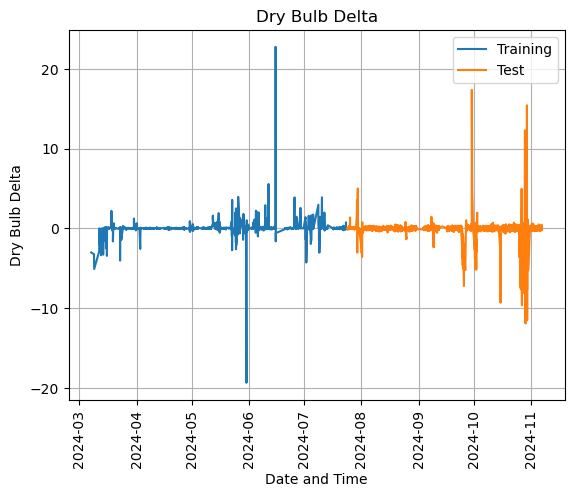

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_74 (InputLayer)          │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_296 (LSTM)                      │ (None, 1, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_297 (LSTM)                      │ (None, 4)                   │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_74 (RepeatVector)      │ (None, 1, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_298 (LSTM)                      │ (None, 1, 4)                │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_299 (LSTM)                      │ (None, 1, 16)               │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_74                  │ (None, 1, 1)                │              17 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,993 (11.69 KB)

 Trainable params: 2,993 (11.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.3682 - val_loss: 0.0012
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 9/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 10/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 11/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 12/100
238/238 ━━━━━━━━━━━━━━━━━━━

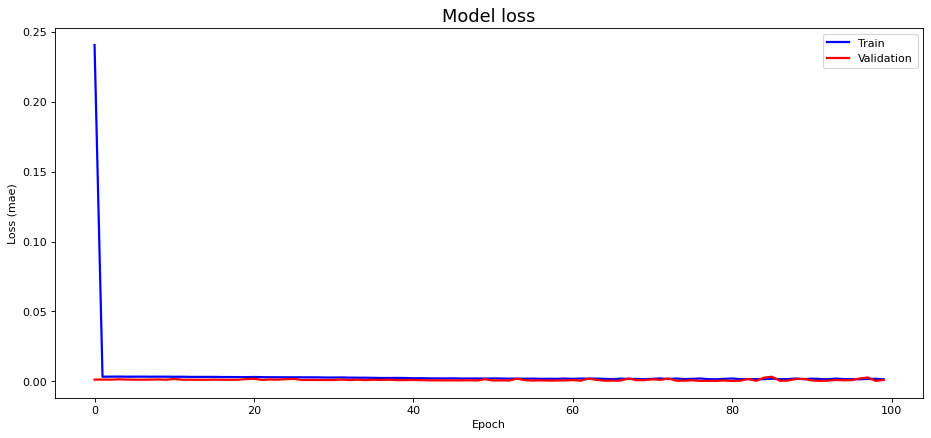

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


C:\Users\Daniel Hardiman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


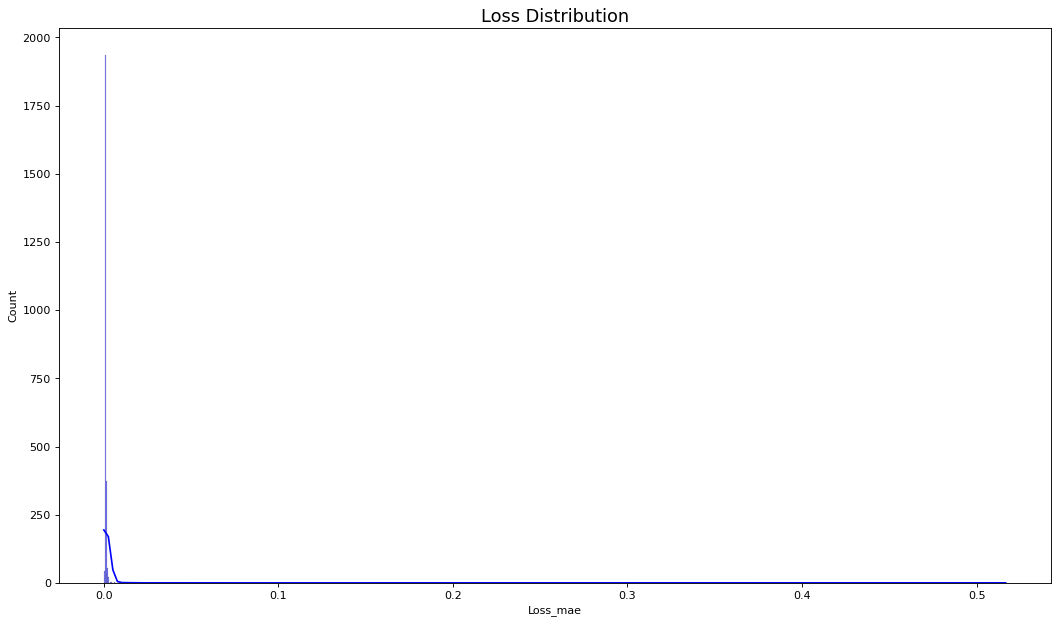

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
      Loss_mae  Threshold  Anomaly       Date and Time
0     0.012201    0.03573    False 2024-03-07 09:45:00
1     0.013704    0.03573    False 2024-03-08 22:15:00
2     0.028462    0.03573    False 2024-03-09 00:30:00
3     0.011292    0.03573    False 2024-03-11 18:00:00
4     0.000916    0.03573    False 2024-03-11 19:00:00
...        ...        ...      ...                 ...
6672  0.000446    0.03573    False 2024-11-06 20:00:00
6673  0.000511    0.03573    False 2024-11-06 20:15:00
6674  0.000584    0.03573    False 2024-11-06 22:00:00
6675  0.000620    0.03573    False 2024-11-06 23:45:00
6676  0.000900    0.03573    False 2024-11-07 01:15:00

[6677 rows x 4 columns]
0.5166128873825073
0.0009798536108919786


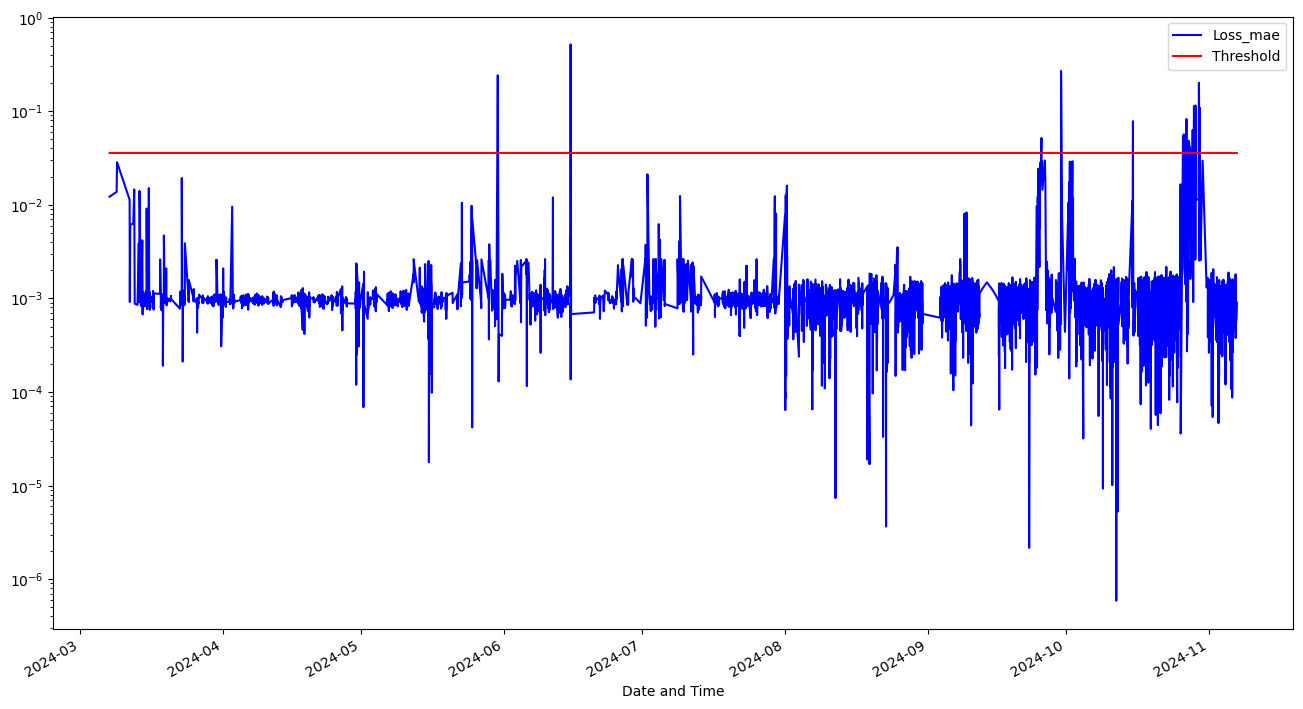

In [359]:
# Dry bulb
model_drybulb, scaler_drybulb, thresh_drybulb = train_test_model(df_filter, 'Dry Bulb Delta', 2500, True)

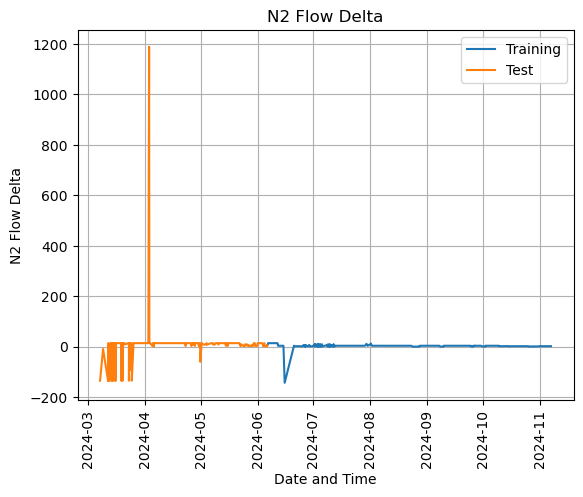

Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_75 (InputLayer)          │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_300 (LSTM)                      │ (None, 1, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_301 (LSTM)                      │ (None, 4)                   │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_75 (RepeatVector)      │ (None, 1, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_302 (LSTM)                      │ (None, 1, 4)                │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_303 (LSTM)                      │ (None, 1, 16)               │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_75                  │ (None, 1, 1)                │              17 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,993 (11.69 KB)

 Trainable params: 2,993 (11.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.8093 - val_loss: 0.4318
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3205 - val_loss: 0.0108
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0088 - val_loss: 0.0109
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0088 - val_loss: 0.0110
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0088 - val_loss: 0.0111
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0089 - val_loss: 0.0111
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0088 - val_loss: 0.0109
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0088 - val_loss: 0.0109
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0089 - val_loss: 0.0109
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0089 - val_loss: 0.0109
Epoch 11/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0088 - val_loss: 0.0110
Epoch 12/100
492/492 ━━━━━━━━━━━━━━━━━━━

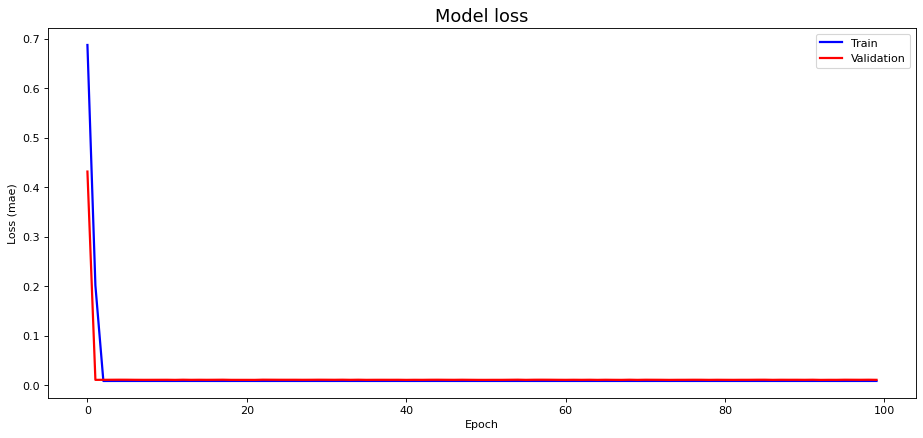

162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


C:\Users\Daniel Hardiman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


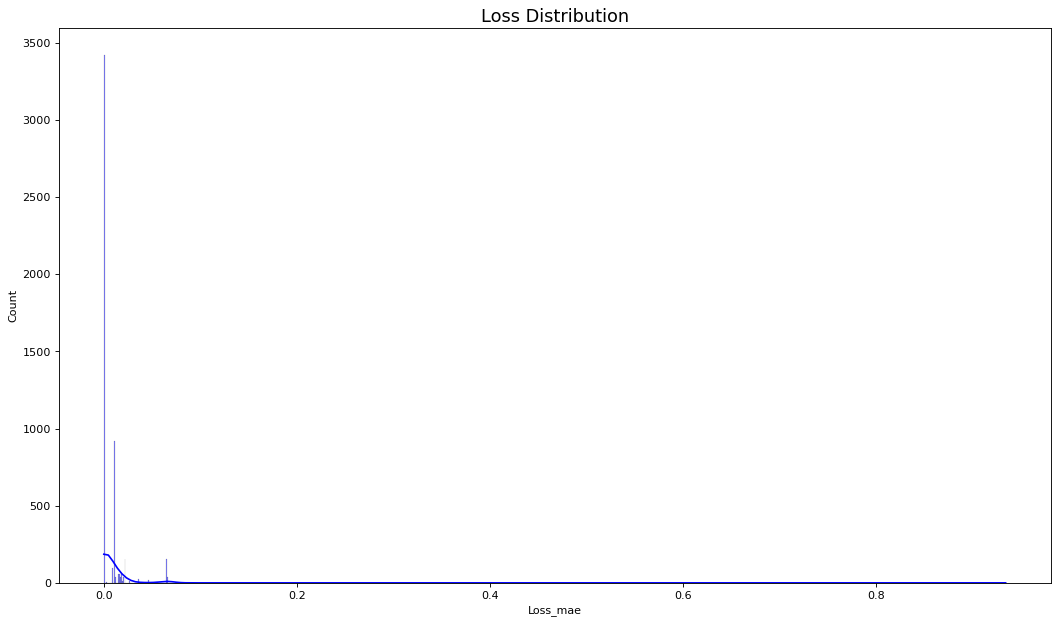

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
      Loss_mae  Threshold  Anomaly       Date and Time
1500  0.002339   0.137364    False 2024-06-05 23:00:00
1501  0.007313   0.137364    False 2024-06-05 23:45:00
1502  0.017021   0.137364    False 2024-06-06 07:30:00
1503  0.065414   0.137364    False 2024-06-06 13:30:00
1504  0.065278   0.137364    False 2024-06-06 13:45:00
...        ...        ...      ...                 ...
1495  0.012029   0.137364    False 2024-06-05 18:30:00
1496  0.002339   0.137364    False 2024-06-05 19:15:00
1497  0.017021   0.137364    False 2024-06-05 20:30:00
1498  0.012029   0.137364    False 2024-06-05 21:00:00
1499  0.012029   0.137364    False 2024-06-05 22:15:00

[6677 rows x 4 columns]
7.541901723191632
0.0002860177232704153


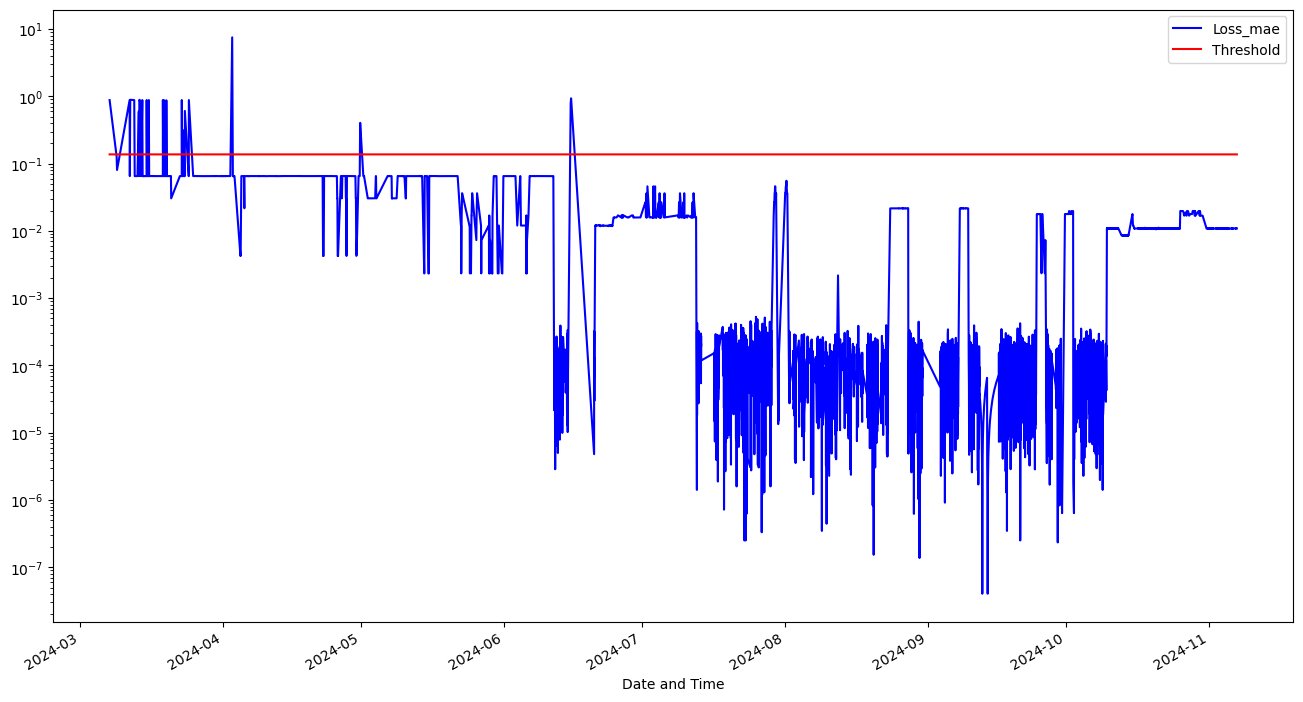

In [360]:
# N2 flow
model_N2, scaler_N2, thresh_N2 = train_test_model(df_filter, 'N2 Flow Delta', 1500, False)

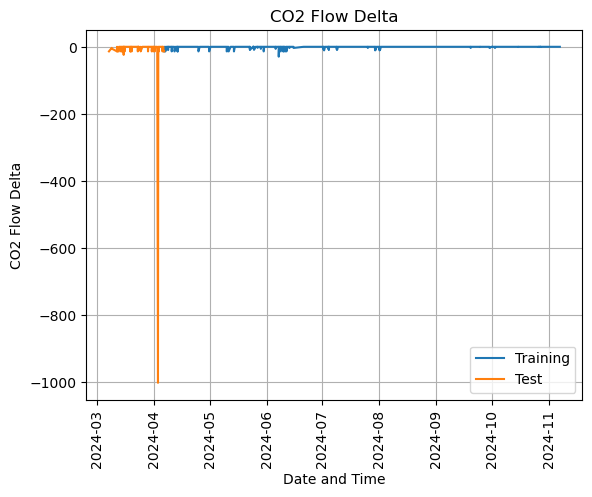

Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_76 (InputLayer)          │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_304 (LSTM)                      │ (None, 1, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_305 (LSTM)                      │ (None, 4)                   │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_76 (RepeatVector)      │ (None, 1, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_306 (LSTM)                      │ (None, 1, 4)                │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_307 (LSTM)                      │ (None, 1, 16)               │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_76                  │ (None, 1, 1)                │              17 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,993 (11.69 KB)

 Trainable params: 2,993 (11.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.6609 - val_loss: 0.0011
Epoch 2/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0082 - val_loss: 4.6118e-04
Epoch 3/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0080 - val_loss: 0.0015
Epoch 4/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0081 - val_loss: 0.0010
Epoch 5/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0081 - val_loss: 8.8517e-04
Epoch 6/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0080 - val_loss: 0.0014
Epoch 7/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0081 - val_loss: 0.0011
Epoch 8/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0081 - val_loss: 3.4188e-04
Epoch 9/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0080 - val_loss: 7.1595e-04
Epoch 10/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0080 - val_loss: 4.1740e-04
Epoch 11/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0079 - val_loss: 3.0789e-04
Epoch 12/100
587

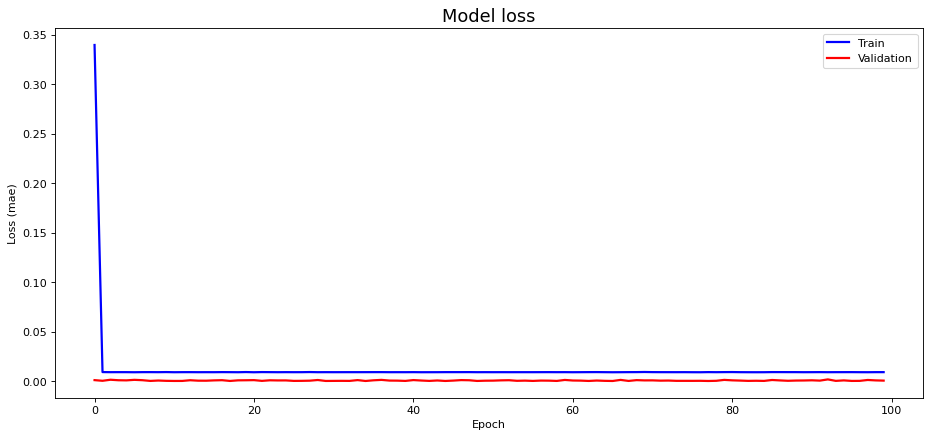

194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


C:\Users\Daniel Hardiman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


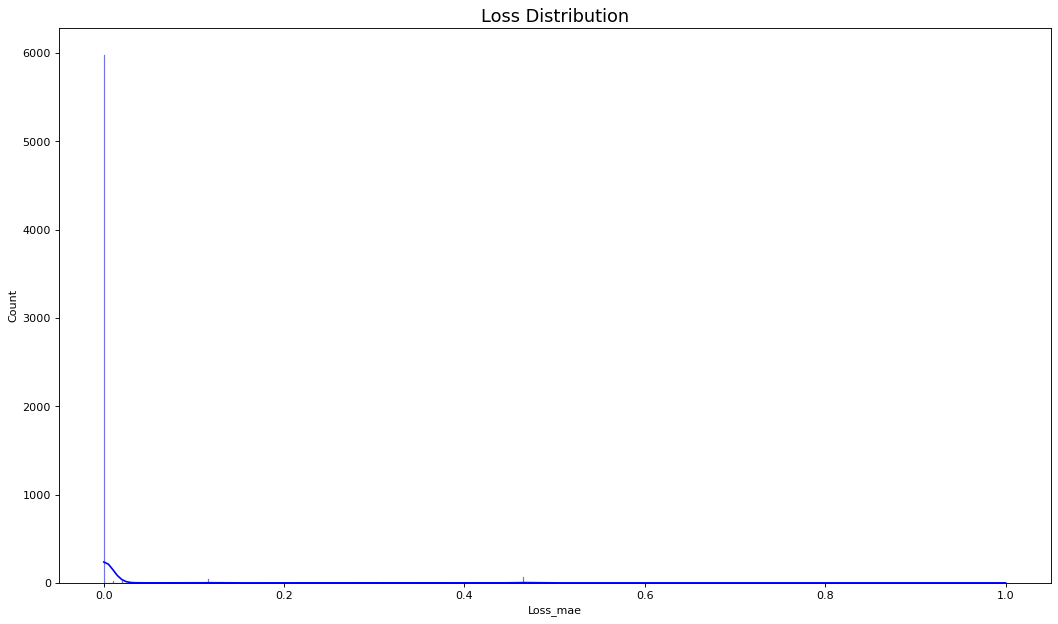

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
     Loss_mae  Threshold  Anomaly       Date and Time
500  0.465443   0.182682     True 2024-04-06 09:30:00
501  0.465504   0.182682     True 2024-04-06 09:45:00
502  0.465469   0.182682     True 2024-04-06 10:00:00
503  0.465445   0.182682     True 2024-04-06 10:15:00
504  0.465456   0.182682     True 2024-04-06 10:30:00
..        ...        ...      ...                 ...
495  0.465402   0.182682     True 2024-04-06 08:15:00
496  0.465444   0.182682     True 2024-04-06 08:30:00
497  0.465448   0.182682     True 2024-04-06 08:45:00
498  0.465456   0.182682     True 2024-04-06 09:00:00
499  0.465523   0.182682     True 2024-04-06 09:15:00

[6677 rows x 4 columns]
34.05533066313233
0.0003636111210894022


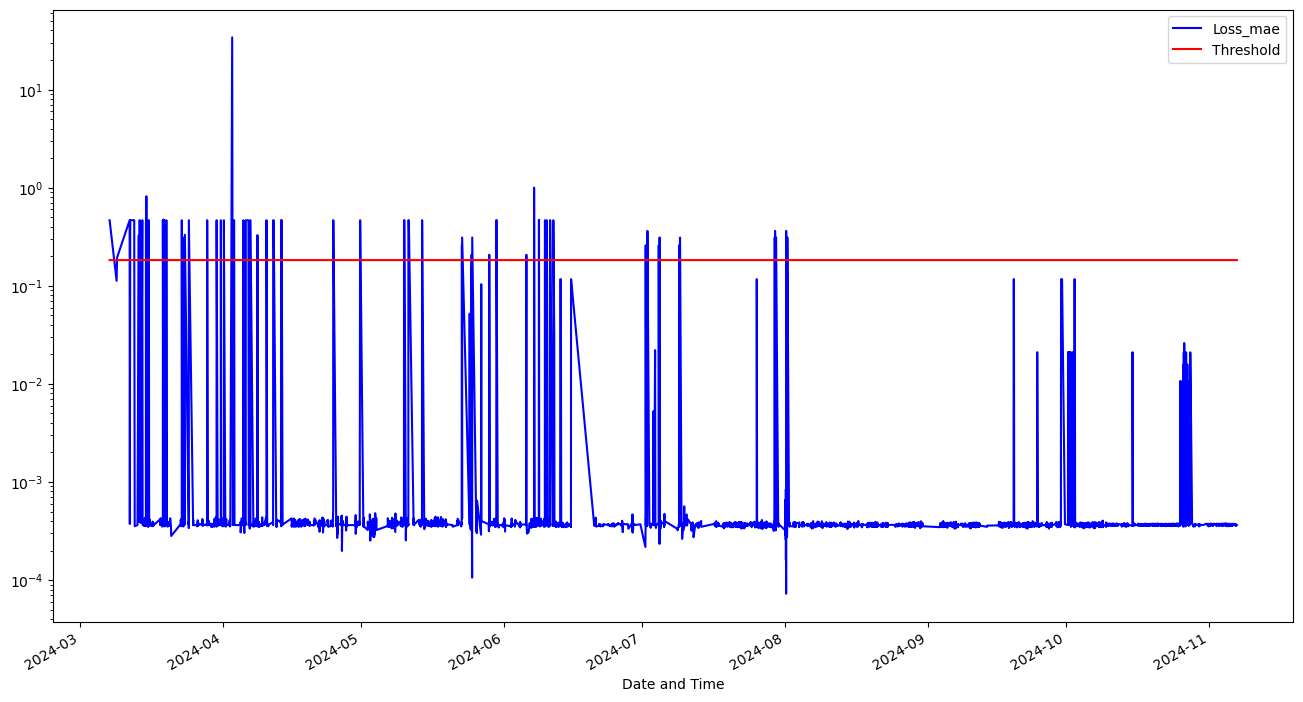

In [361]:
# CO2 flow
model_CO2, scaler_CO2, thresh_CO2 = train_test_model(df_filter, 'CO2 Flow Delta', 500, False)

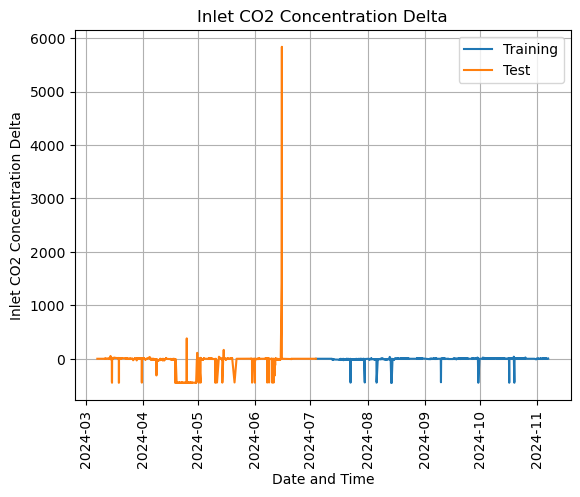

Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_77 (InputLayer)          │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_308 (LSTM)                      │ (None, 1, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_309 (LSTM)                      │ (None, 4)                   │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_77 (RepeatVector)      │ (None, 1, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_310 (LSTM)                      │ (None, 1, 4)                │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_311 (LSTM)                      │ (None, 1, 16)               │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_77                  │ (None, 1, 1)                │              17 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,993 (11.69 KB)

 Trainable params: 2,993 (11.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.5726 - val_loss: 0.0019
Epoch 2/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 3/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0096 - val_loss: 0.0036
Epoch 4/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0082 - val_loss: 0.0025
Epoch 5/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0069 - val_loss: 2.0619e-04
Epoch 6/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0065 - val_loss: 0.0017
Epoch 7/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0064 - val_loss: 0.0025
Epoch 8/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0069 - val_loss: 0.0015
Epoch 9/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0060 - val_loss: 0.0027
Epoch 10/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0066 - val_loss: 4.7252e-04
Epoch 11/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0058 - val_loss: 0.0021
Epoch 12/100
445/445 ━━━━━━━━━━━

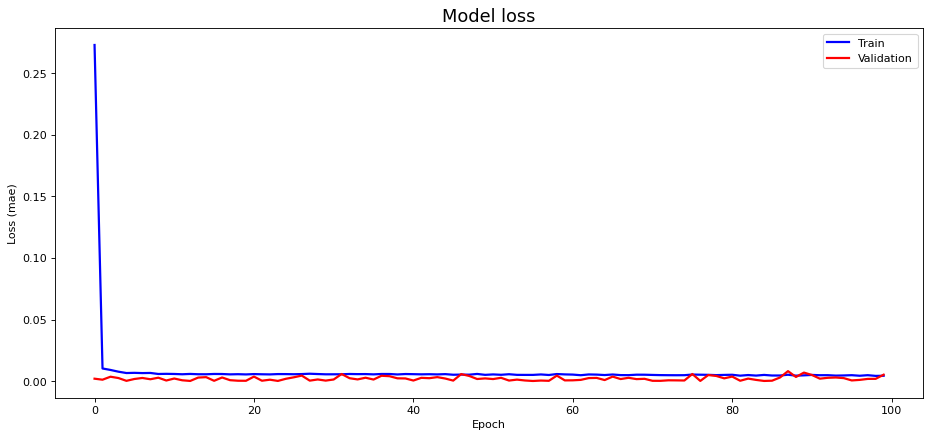

147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


C:\Users\Daniel Hardiman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


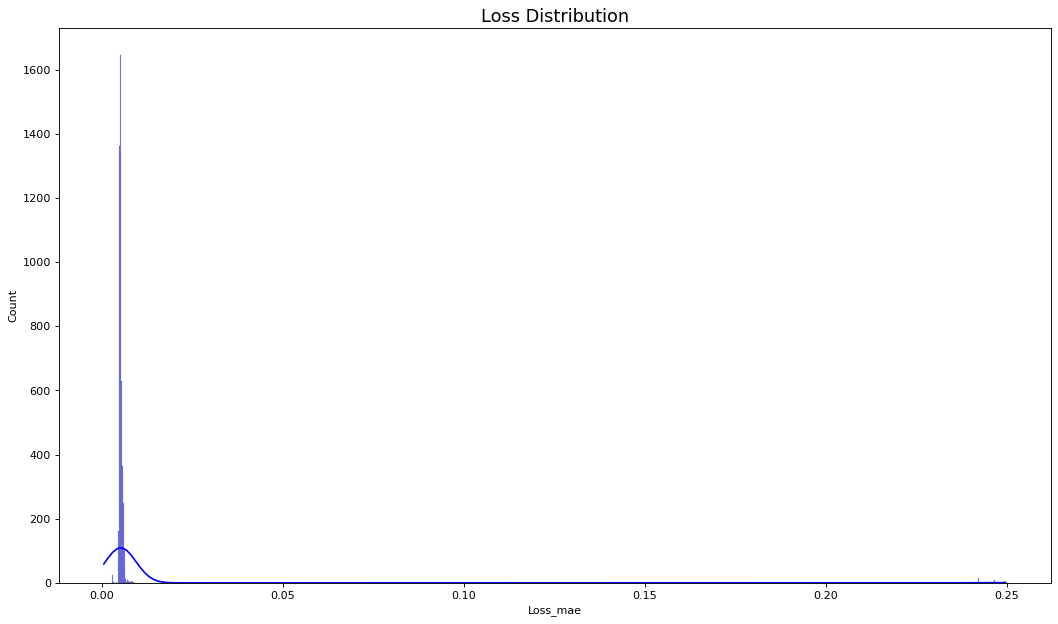

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
      Loss_mae  Threshold  Anomaly       Date and Time
2000  0.005206   0.075288    False 2024-07-04 00:45:00
2001  0.005206   0.075288    False 2024-07-04 01:00:00
2002  0.005206   0.075288    False 2024-07-04 02:15:00
2003  0.005206   0.075288    False 2024-07-04 02:30:00
2004  0.005206   0.075288    False 2024-07-04 13:45:00
...        ...        ...      ...                 ...
1995  0.005206   0.075288    False 2024-07-03 20:15:00
1996  0.005206   0.075288    False 2024-07-03 20:30:00
1997  0.005206   0.075288    False 2024-07-03 21:45:00
1998  0.005206   0.075288    False 2024-07-03 22:00:00
1999  0.005206   0.075288    False 2024-07-03 23:30:00

[6677 rows x 4 columns]
37.51374054728249
0.005206290297433802


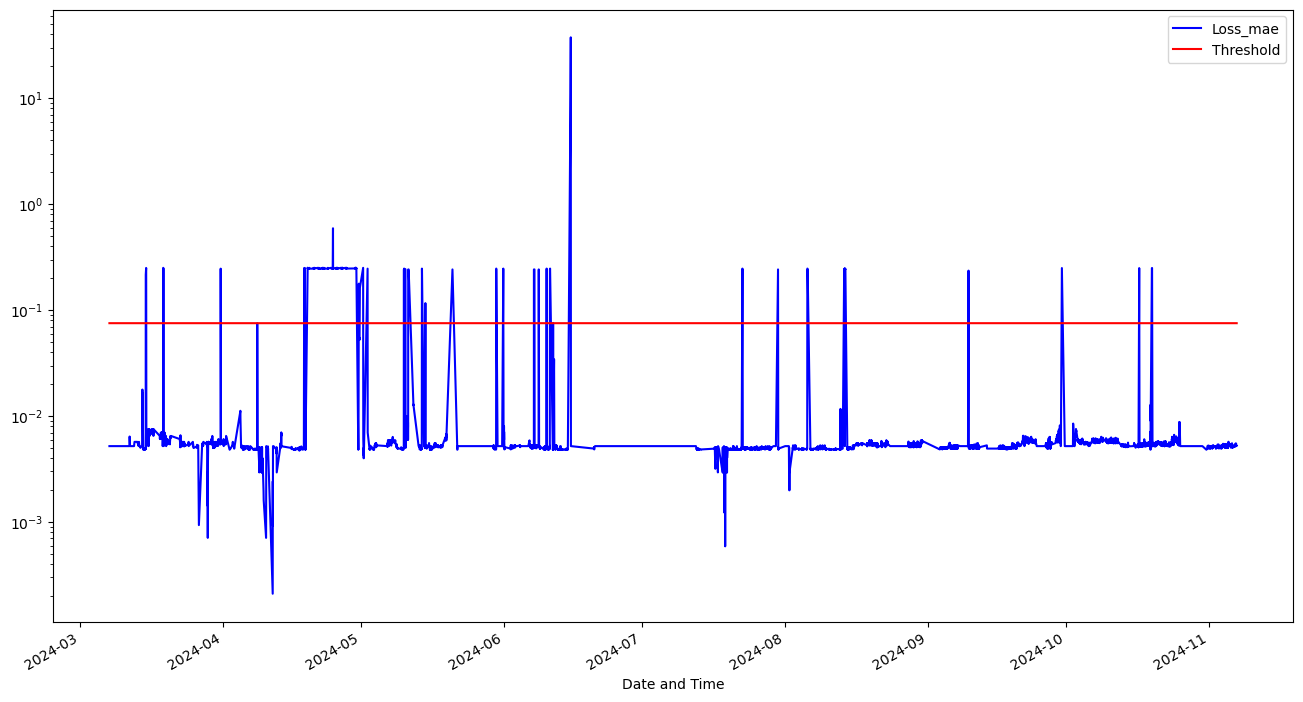

In [362]:
# inlet CO2 concentration
model_CO2inlet, scaler_CO2inlet, thresh_CO2inlet = train_test_model(df_filter, 'Inlet CO2 Concentration Delta', 2000, False)

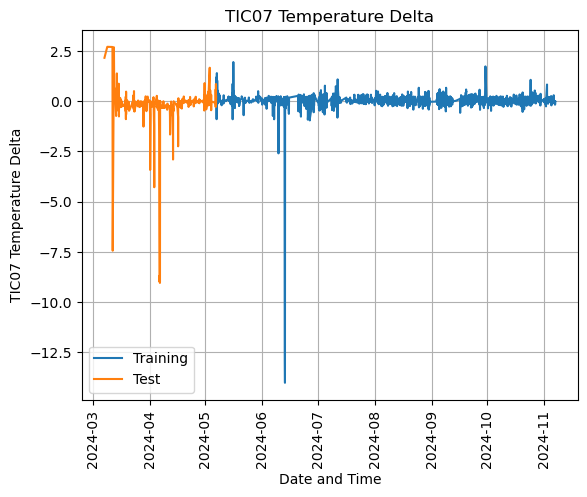

Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_78 (InputLayer)          │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_312 (LSTM)                      │ (None, 1, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_313 (LSTM)                      │ (None, 4)                   │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_78 (RepeatVector)      │ (None, 1, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_314 (LSTM)                      │ (None, 1, 4)                │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_315 (LSTM)                      │ (None, 1, 16)               │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_78                  │ (None, 1, 1)                │              17 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,993 (11.69 KB)

 Trainable params: 2,993 (11.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.4989 - val_loss: 0.0020
Epoch 2/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 3/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 4/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 5/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 6/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 7/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 8/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 9/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 10/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 11/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 12/100
540/540 ━━━━━━━━━━━━━━━━━━━

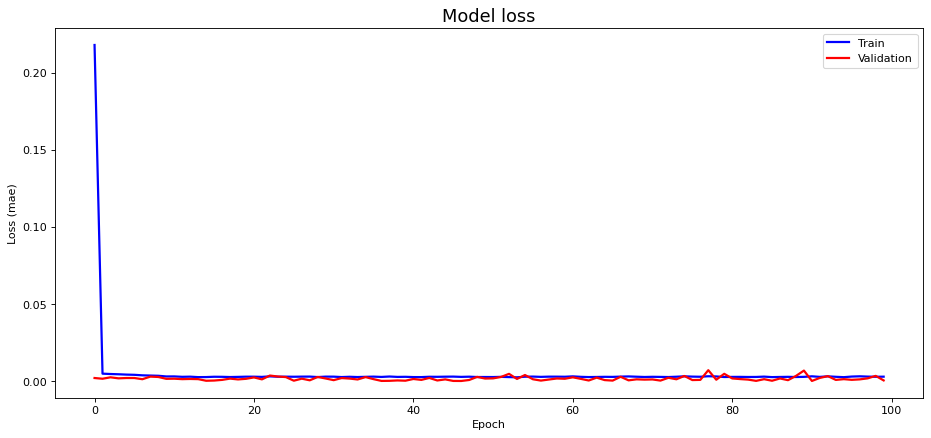

178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


C:\Users\Daniel Hardiman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


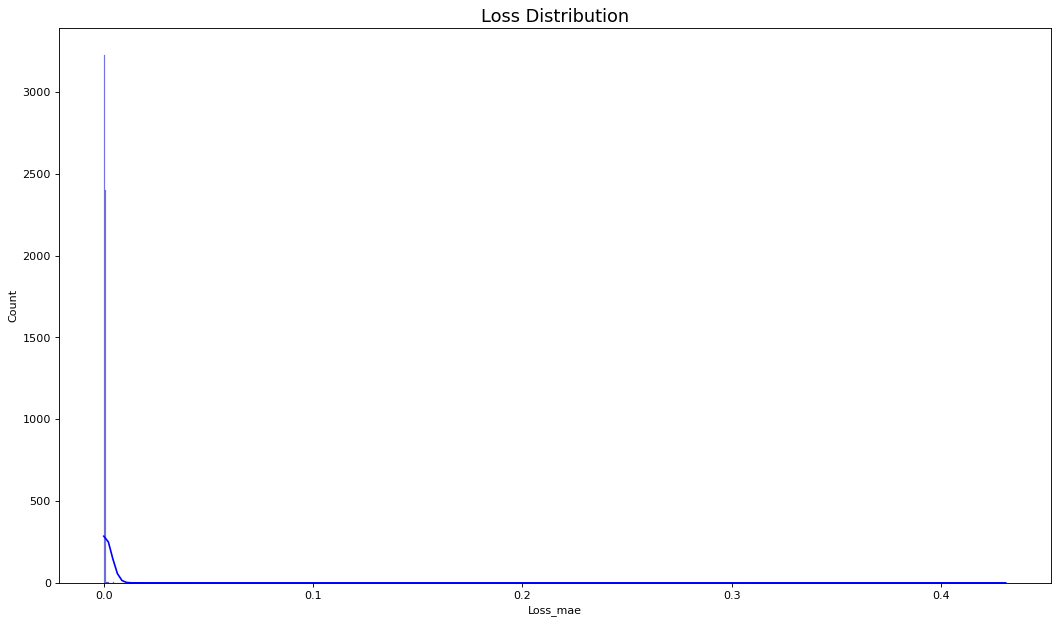

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
      Loss_mae  Threshold  Anomaly       Date and Time
1000  0.000393   0.058594    False 2024-05-07 00:00:00
1001  0.000378   0.058594    False 2024-05-07 00:15:00
1002  0.000274   0.058594    False 2024-05-07 00:30:00
1003  0.004863   0.058594    False 2024-05-07 00:45:00
1004  0.000072   0.058594    False 2024-05-07 02:30:00
...        ...        ...      ...                 ...
995   0.000149   0.058594    False 2024-05-06 21:15:00
996   0.002386   0.058594    False 2024-05-06 21:30:00
997   0.000358   0.058594    False 2024-05-06 21:45:00
998   0.000187   0.058594    False 2024-05-06 23:30:00
999   0.000174   0.058594    False 2024-05-06 23:45:00

[6677 rows x 4 columns]
0.4308456778526306
0.00042929950836489983


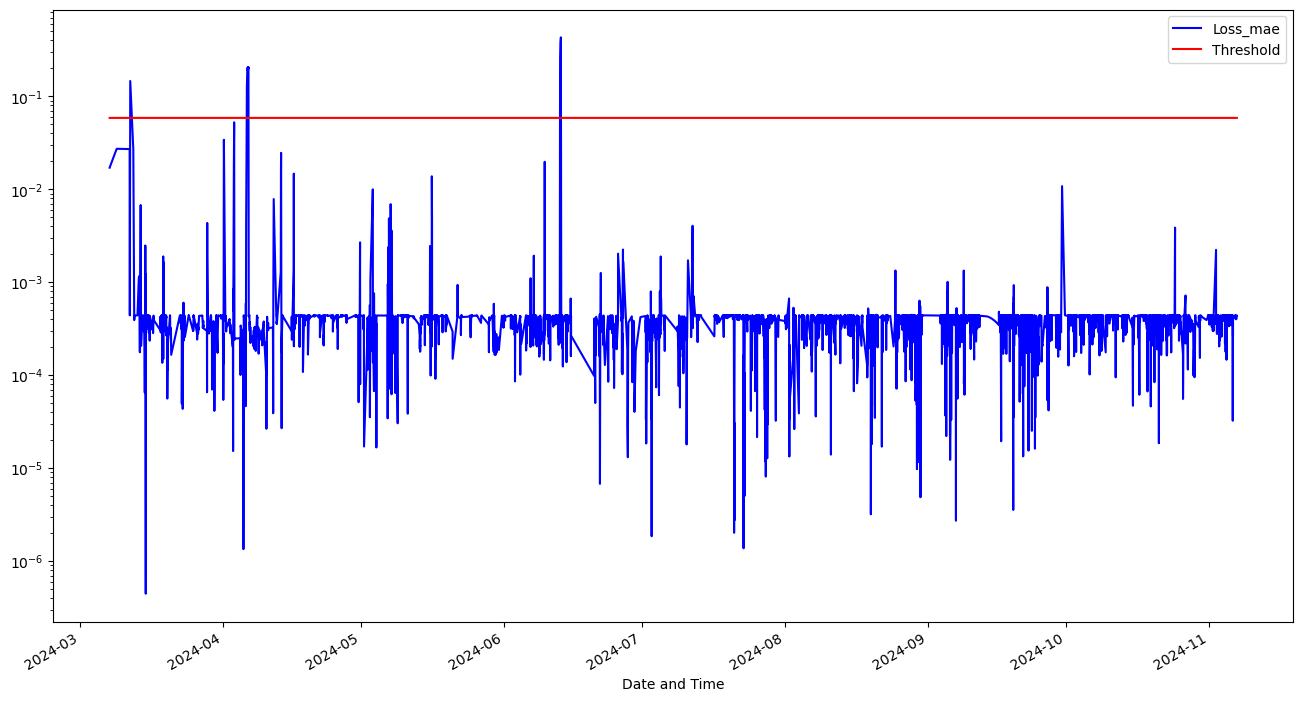

In [363]:
# TIC07 temperature
model_TIC07, scaler_TIC07, thresh_TIC07 = train_test_model(df_filter, 'TIC07 Temperature Delta', 1000, False)

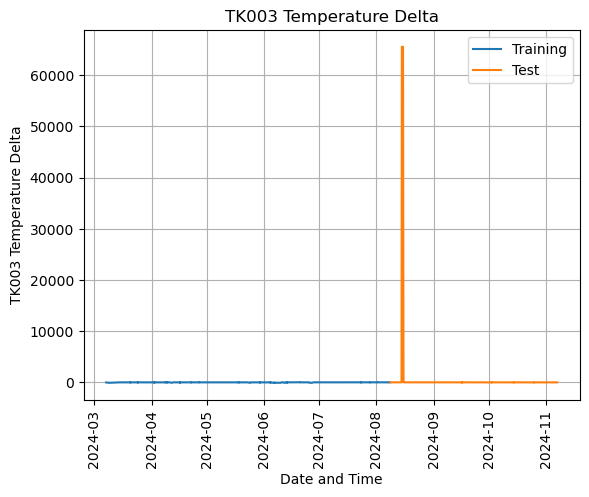

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_79 (InputLayer)          │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_316 (LSTM)                      │ (None, 1, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_317 (LSTM)                      │ (None, 4)                   │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_79 (RepeatVector)      │ (None, 1, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_318 (LSTM)                      │ (None, 1, 4)                │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_319 (LSTM)                      │ (None, 1, 16)               │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_79                  │ (None, 1, 1)                │              17 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,993 (11.69 KB)

 Trainable params: 2,993 (11.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.4115 - val_loss: 0.0318
Epoch 2/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0538 - val_loss: 0.0273
Epoch 3/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0464 - val_loss: 0.0209
Epoch 4/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0355 - val_loss: 0.0036
Epoch 5/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0253 - val_loss: 0.0051
Epoch 6/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0221 - val_loss: 0.0060
Epoch 7/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0217 - val_loss: 0.0085
Epoch 8/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0211 - val_loss: 0.0100
Epoch 9/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0213 - val_loss: 0.0105
Epoch 10/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0206 - val_loss: 0.0096
Epoch 11/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0202 - val_loss: 0.0114
Epoch 12/100
285/285 ━━━━━━━━━━━━━━━━━━━

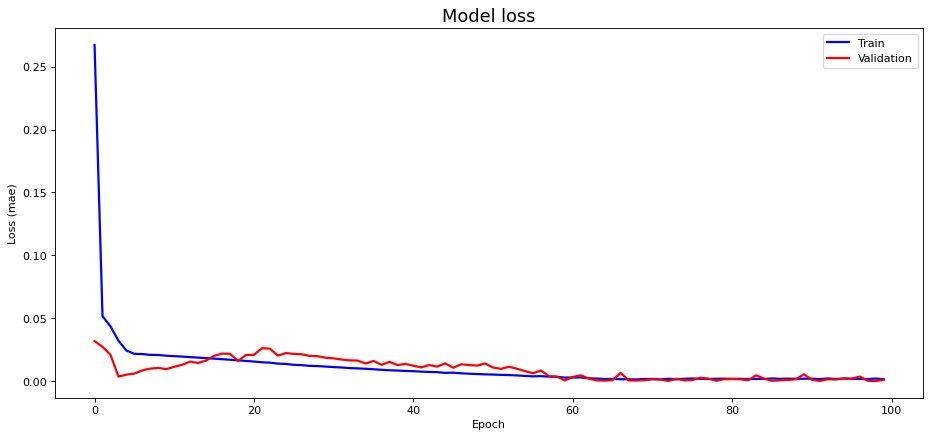

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


C:\Users\Daniel Hardiman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


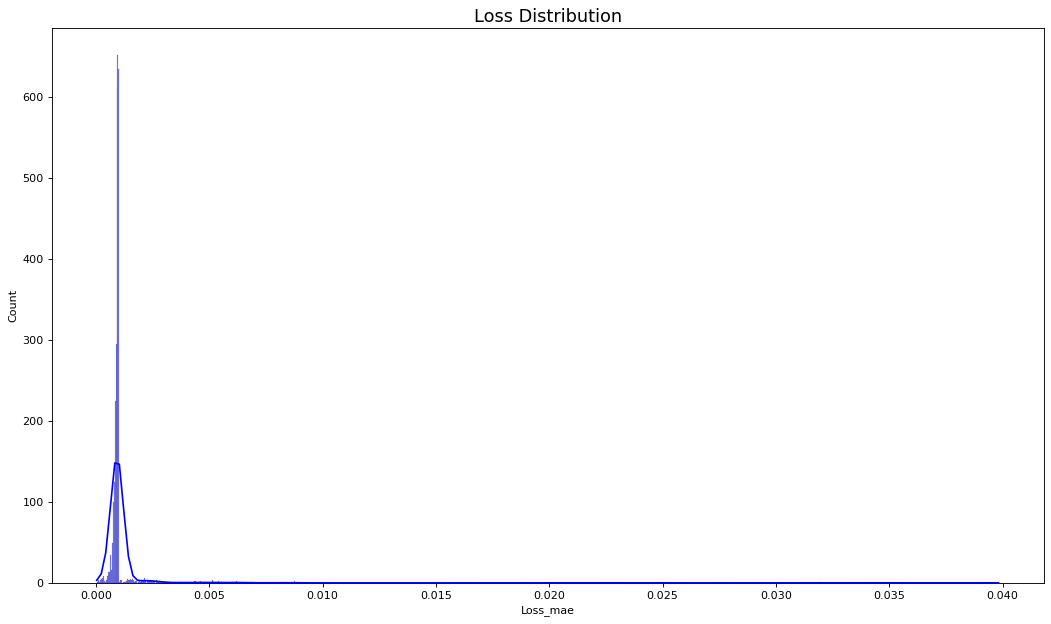

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
      Loss_mae  Threshold  Anomaly       Date and Time
0     0.002108   0.005099    False 2024-03-07 09:45:00
1     0.003788   0.005099    False 2024-03-08 22:15:00
2     0.003987   0.005099    False 2024-03-09 00:30:00
3     0.005971   0.005099     True 2024-03-11 18:00:00
4     0.006937   0.005099     True 2024-03-11 19:00:00
...        ...        ...      ...                 ...
6672  0.000835   0.005099    False 2024-11-06 20:00:00
6673  0.000836   0.005099    False 2024-11-06 20:15:00
6674  0.000831   0.005099    False 2024-11-06 22:00:00
6675  0.000829   0.005099    False 2024-11-06 23:45:00
6676  0.000832   0.005099    False 2024-11-07 01:15:00

[6677 rows x 4 columns]
422.8419220701019
0.0009692201727390382


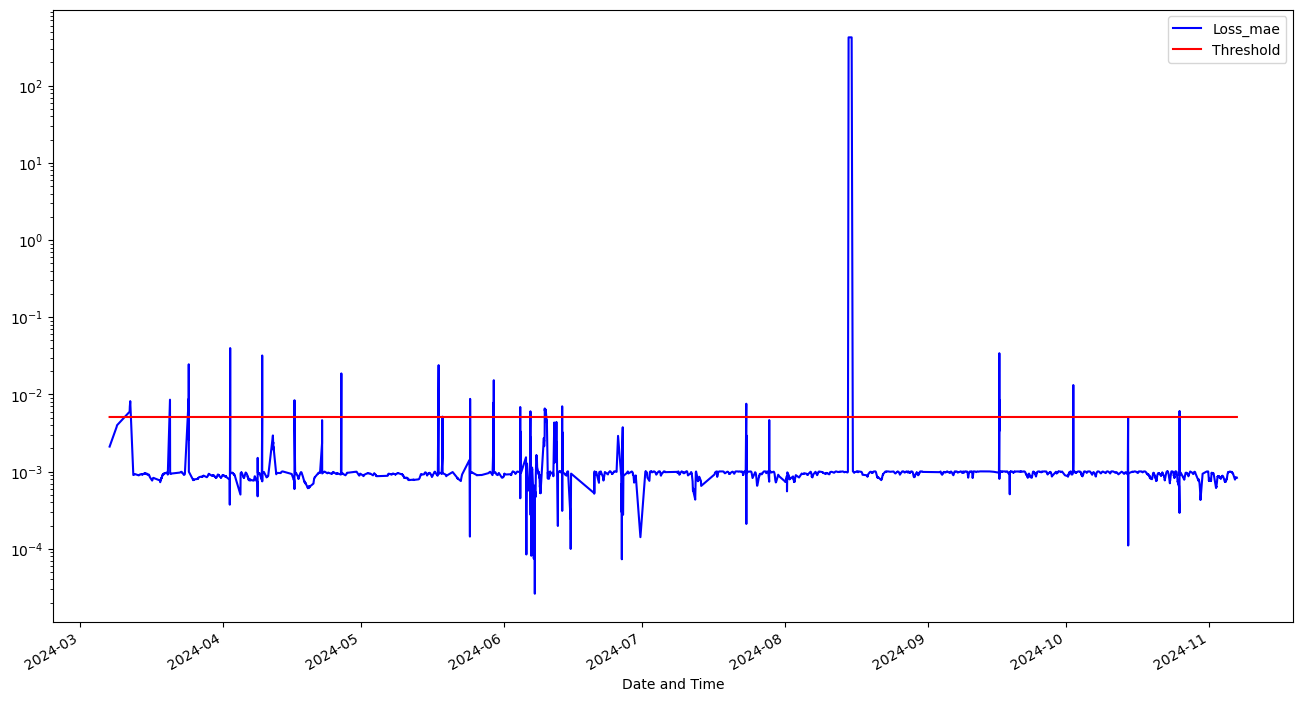

In [364]:
# TK003 temperature
model_TK003, scaler_TK003, thresh_TK003 = train_test_model(df_filter, 'TK003 Temperature Delta', 3000, True)

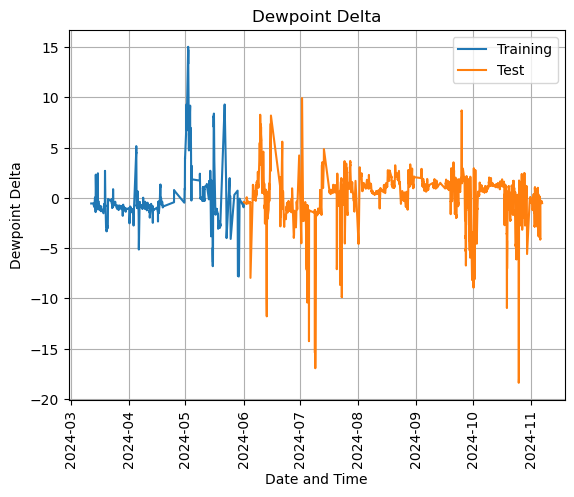

Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_80 (InputLayer)          │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_320 (LSTM)                      │ (None, 1, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_321 (LSTM)                      │ (None, 4)                   │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_80 (RepeatVector)      │ (None, 1, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_322 (LSTM)                      │ (None, 1, 4)                │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_323 (LSTM)                      │ (None, 1, 16)               │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_80                  │ (None, 1, 1)                │              17 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,993 (11.69 KB)

 Trainable params: 2,993 (11.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.2954 - val_loss: 0.1746
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0981 - val_loss: 0.1166
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0531 - val_loss: 0.1157
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0526 - val_loss: 0.1132
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0515 - val_loss: 0.1077
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0470 - val_loss: 0.0832
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323 - val_loss: 0.0499
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0179 - val_loss: 0.0504
Epoch 9/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - val_loss: 0.0493
Epoch 10/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164 - val_loss: 0.0484
Epoch 11/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0472
Epoch 12/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0

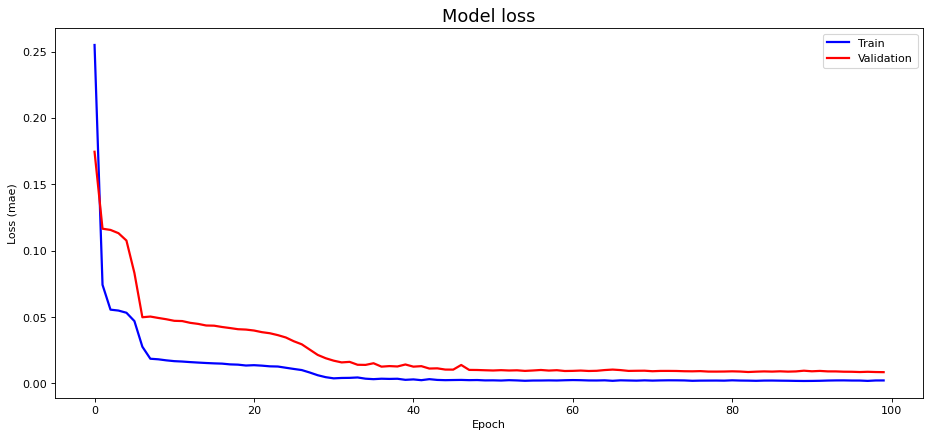

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


C:\Users\Daniel Hardiman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


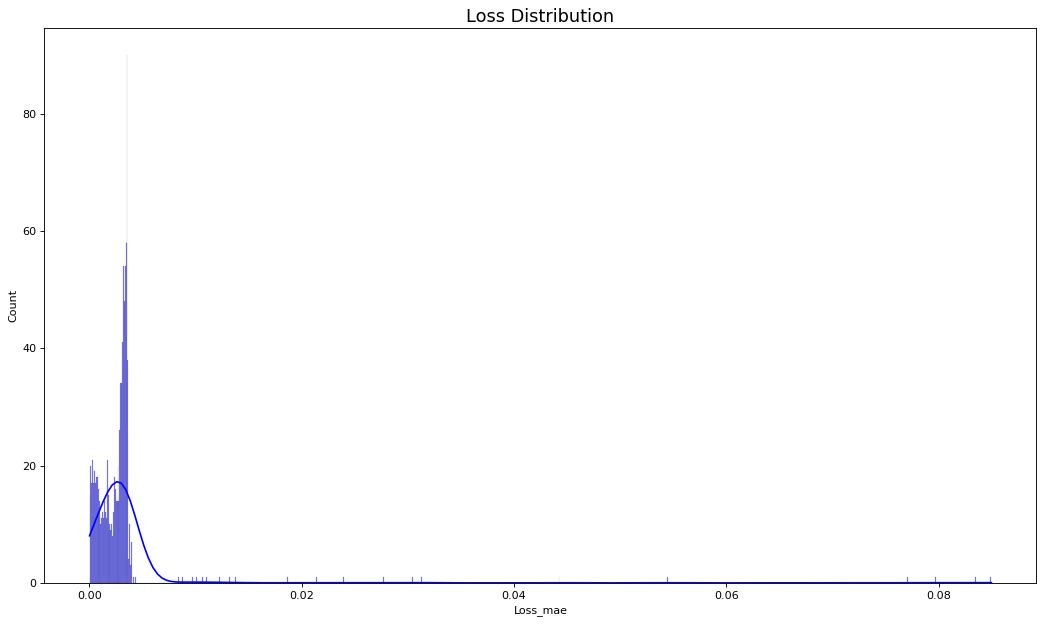

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
      Loss_mae  Threshold  Anomaly       Date and Time
0     0.002329   0.020601    False 2024-03-07 09:45:00
1     0.002295   0.020601    False 2024-03-08 22:15:00
2     0.003204   0.020601    False 2024-03-09 00:30:00
3     0.000327   0.020601    False 2024-03-11 18:00:00
4     0.003580   0.020601    False 2024-03-11 19:00:00
...        ...        ...      ...                 ...
5980  0.001924   0.020601    False 2024-10-19 05:00:00
5981  0.002083   0.020601    False 2024-10-19 05:15:00
5982  0.002068   0.020601    False 2024-10-19 07:15:00
5983  0.001970   0.020601    False 2024-10-19 07:30:00
5984  0.002214   0.020601    False 2024-10-19 07:45:00

[5985 rows x 4 columns]
0.5018223063166979
0.0016727763232867177


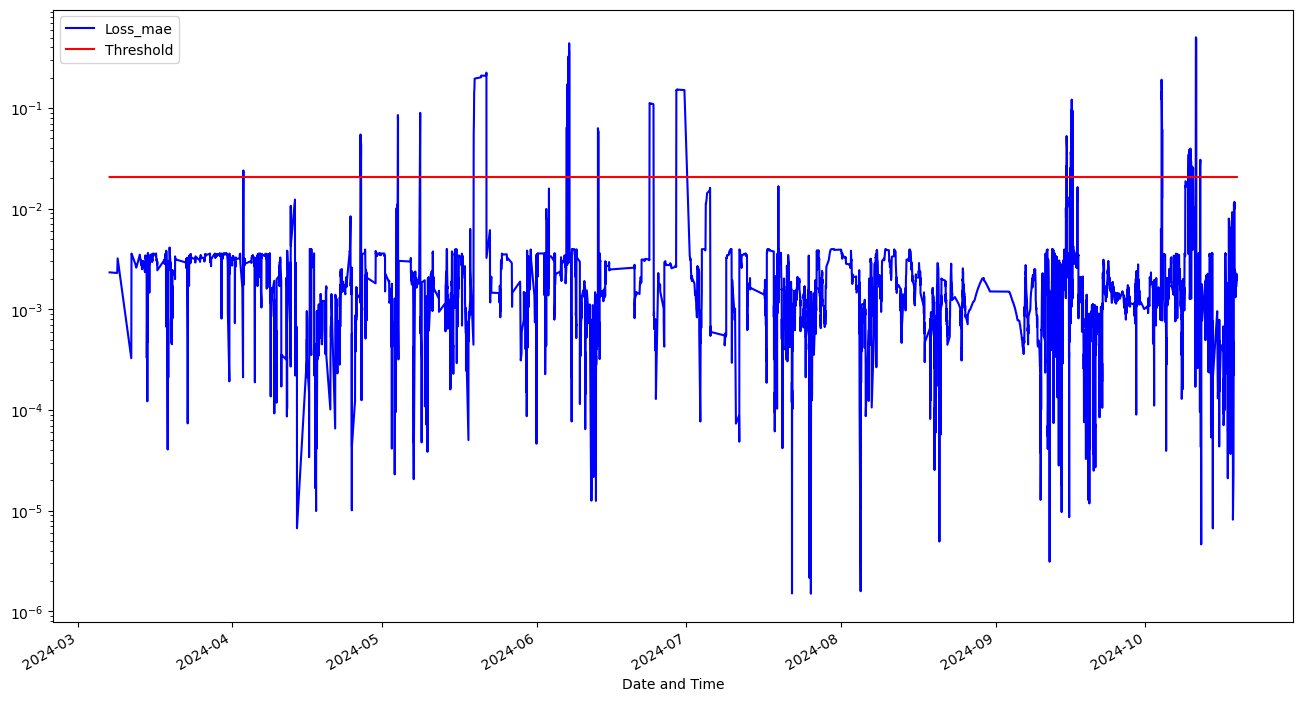

In [365]:
# Dewpoint
model_dewpoint, scaler_dewpoint, thresh_dewpoint = train_test_model(df_filter, 'Dewpoint Delta', 1000, True)

In [311]:
# Create dictionary of models, thresholds, and column names
model_dict = {'Dry Bulb': {'Model': model_drybulb, 'Scaler': scaler_drybulb, 'Threshold': thresh_drybulb, 'Column': 'Dry Bulb Delta'},
             'N2 Flow': {'Model': model_N2, 'Scaler': scaler_N2, 'Threshold': thresh_N2, 'Column': 'N2 Flow Delta'},
             'CO2 Flow': {'Model': model_CO2, 'Scaler': scaler_CO2, 'Threshold': thresh_CO2, 'Column': 'CO2 Flow Delta'},
             'CO2 Concentration': {'Model': model_CO2inlet, 'Scaler': scaler_CO2inlet, 'Threshold': thresh_CO2inlet, 'Column': 'Inlet CO2 Concentration Delta'},
             'TIC07': {'Model': model_TIC07, 'Scaler': scaler_TIC07, 'Threshold': thresh_TIC07, 'Column': 'TIC07 Temperature Delta'},
             'TK003': {'Model': model_TK003, 'Scaler': scaler_TK003, 'Threshold': thresh_TK003, 'Column': 'TK003 Temperature Delta'},
             'Dewpoint': {'Model': model_dewpoint, 'Scaler': scaler_dewpoint, 'Threshold': thresh_dewpoint, 'Column': 'Dewpoint Delta'}}

## Testing

In [334]:
## Pull most recent data for testing
start_date = '20-Nov-2024 06:00:00'
end_date = '20-Nov-2024 09:00:00'

columns = ['TIC11,Feedback', 
           'Loaded Test Parameters,Dry Bulb Setpoint',
           'System State', 
           'Process Gas,N2 Tank Flow Setpoint',
           'Loaded Test Parameters,N2 Tank Flow Setpoint',
           'Process Gas,N2 Tank Flow Feedback',
           'Process Gas,CO2 Tank Flow Setpoint',
           'Loaded Test Parameters,CO2 Tank Flow Setpoint',
           'Process Gas,CO2 Tank Flow Feedback',
           'Loaded Test Parameters,Target CO2 Concentration',
           'AI48,CO2',
           'TK001,TIC07,Setpoint',
           'TK001,TIC07,Feedback',
           'TK003,Temperature Setpoint',
           'TK003,Temperature Feedback',
           'Loaded Test Parameters,Dewpoint Setpoint',
           'AI12,Moisture',
           'AI48,Moisture',
           'PT42,Pressure Feedback']

df_test = retrieve_data(start_date, end_date, columns = columns, frequency = '60s')
# Calculate delta columns
df_test = calculate_deltas(df_test)
df_test

,level_0,index,TIC11_Feedback,Loaded Test Parameters_Dry Bulb Setpoint,System State,Process Gas_N2 Tank Flow Setpoint,Loaded Test Parameters_N2 Tank Flow Setpoint,Process Gas_N2 Tank Flow Feedback,Process Gas_CO2 Tank Flow Setpoint,Loaded Test Parameters_CO2 Tank Flow Setpoint,...,PT42_Pressure Feedback,Date and Time,Dry Bulb Delta,N2 Flow Delta,CO2 Flow Delta,Inlet CO2 Concentration Delta,TIC07 Temperature Delta,TK003 Temperature Delta,Dewpoint,Dewpoint Delta
0,0,2024-11-20 11:00:00+00:00,30.238308,30.0,40,72.302536,72.302536,74.003471,1.700684,1.700684,...,1.213000,2024-11-20 07:00:00,0.238308,1.700935,-0.000226,1.512525,-0.007377,-7.385459,14.114448,-0.885552
1,1,2024-11-20 11:01:00+00:00,29.871342,30.0,40,72.302536,72.302536,73.999603,1.700684,1.700684,...,1.190113,2024-11-20 07:01:00,-0.128658,1.697067,-0.000293,-1.243731,-0.011697,-7.416065,14.092104,-0.907896
2,2,2024-11-20 11:02:00+00:00,29.962517,30.0,40,72.302536,72.302536,74.004898,1.700684,1.700684,...,1.213000,2024-11-20 07:02:00,-0.037483,1.702362,-0.000192,-1.496051,-0.008637,-7.444224,14.083803,-0.916197
3,3,2024-11-20 11:03:00+00:00,30.049587,30.0,40,72.302536,72.302536,74.005493,1.700684,1.700684,...,1.213000,2024-11-20 07:03:00,0.049587,1.702957,0.000083,-2.613879,-0.000976,-7.396489,14.092753,-0.907247
4,4,2024-11-20 11:04:00+00:00,30.378834,30.0,40,72.302536,72.302536,74.003426,1.700684,1.700684,...,1.190113,2024-11-20 07:04:00,0.378834,1.700890,0.000098,-0.631213,0.004292,-7.398502,14.064243,-0.935757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,106,2024-11-20 12:46:00+00:00,29.990131,30.0,40,72.302536,72.302536,74.008064,1.700684,1.700684,...,1.297445,2024-11-20 08:46:00,-0.009869,1.705528,0.000015,-0.747393,-0.003849,-7.837052,13.989561,-1.010439
107,107,2024-11-20 12:47:00+00:00,29.973923,30.0,40,72.302536,72.302536,73.994888,1.700684,1.700684,...,1.350320,2024-11-20 08:47:00,-0.026077,1.692352,-0.000259,0.094465,-0.006206,-8.119051,14.109720,-0.890280
108,108,2024-11-20 12:48:00+00:00,30.049953,30.0,40,72.302536,72.302536,74.000671,1.700684,1.700684,...,1.304547,2024-11-20 08:48:00,0.049953,1.698135,-0.000187,0.001935,-0.089058,-8.132882,14.057899,-0.942101
109,109,2024-11-20 12:49:00+00:00,30.012657,30.0,40,72.302536,72.302536,74.013939,1.700684,1.700684,...,1.299387,2024-11-20 08:49:00,0.012657,1.711403,0.000089,-0.997668,0.067518,-8.381877,14.090904,-0.909096


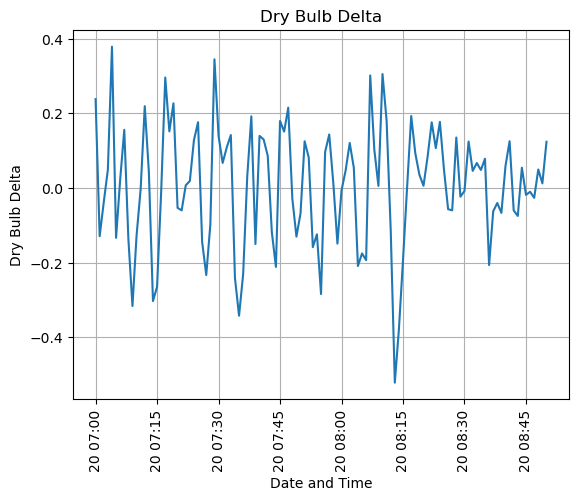

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


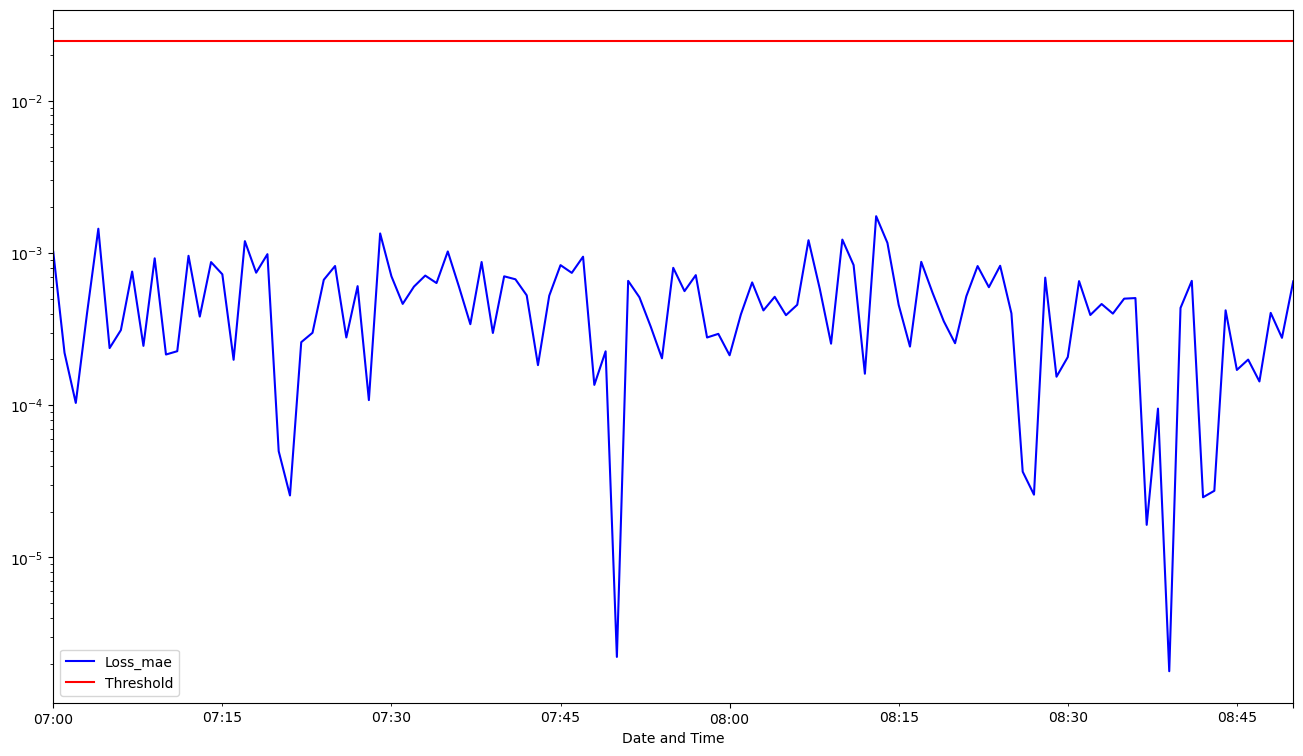

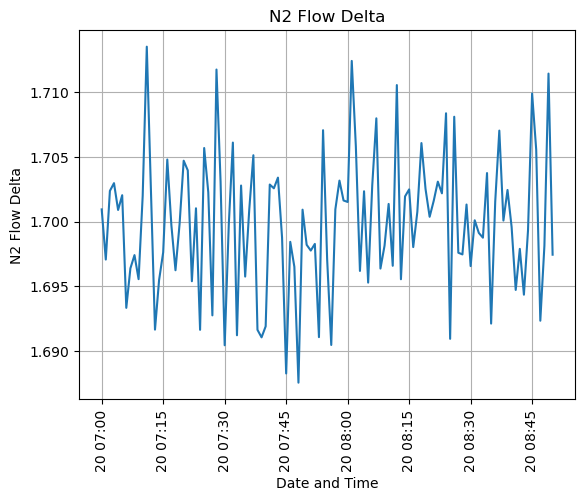

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


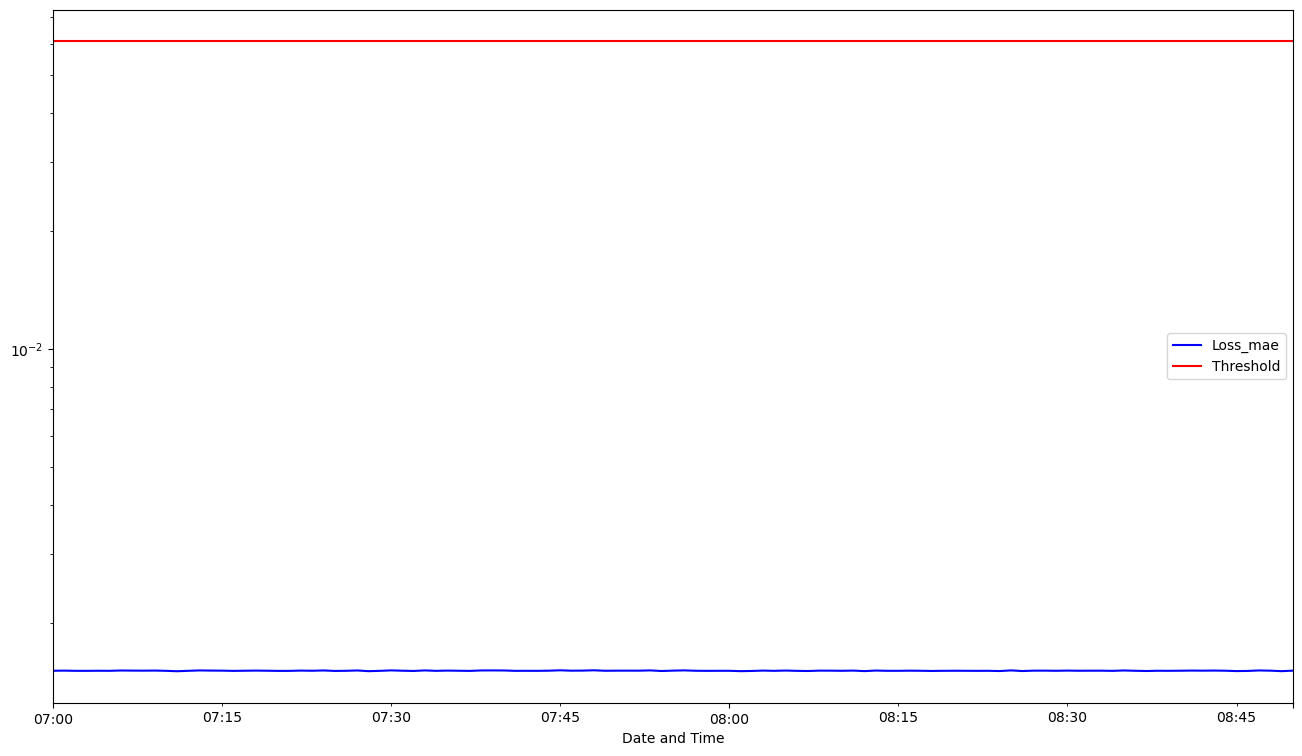

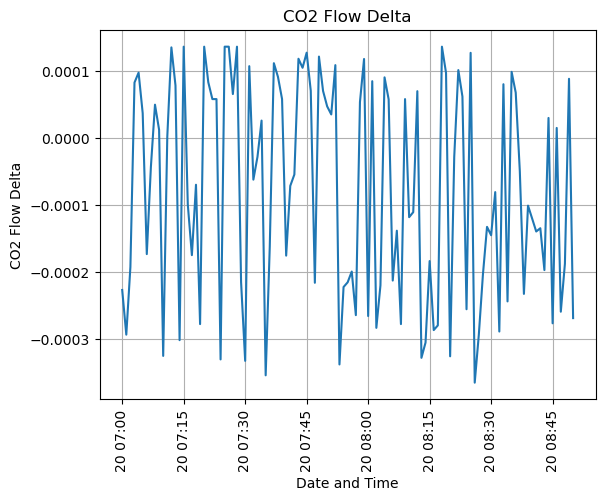

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


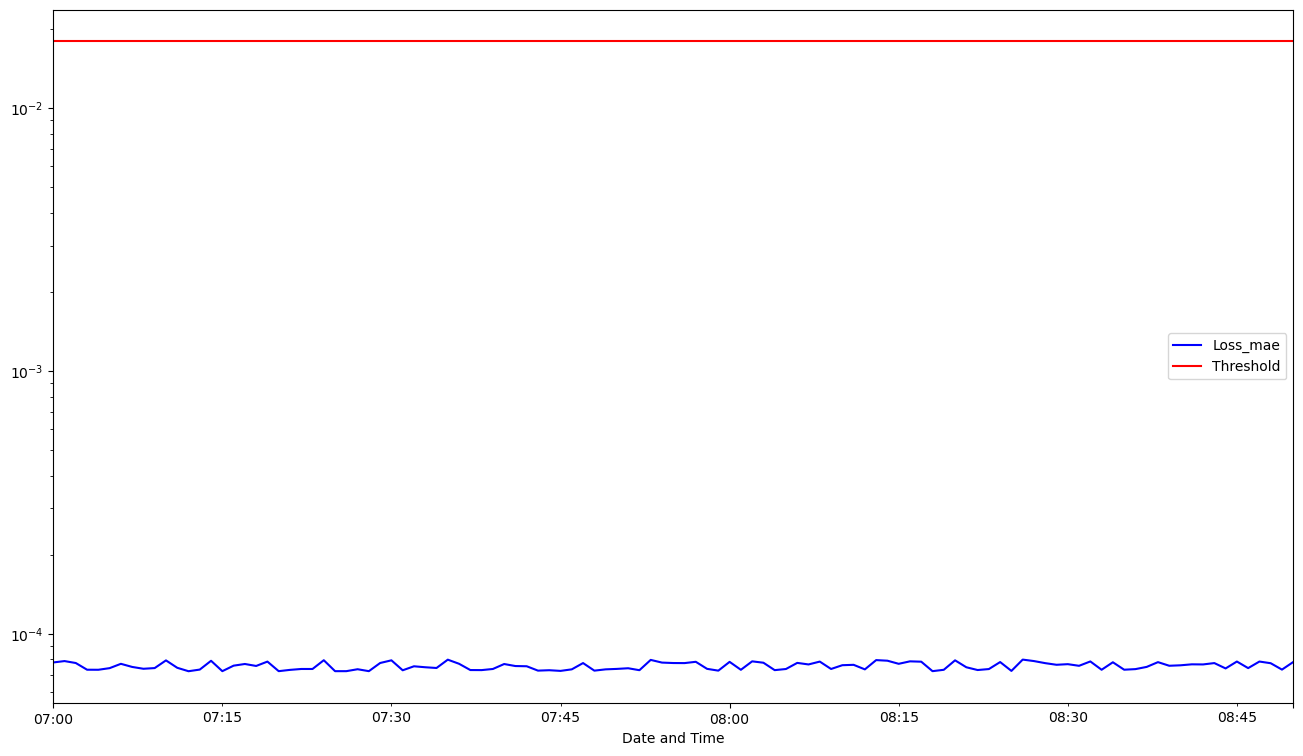

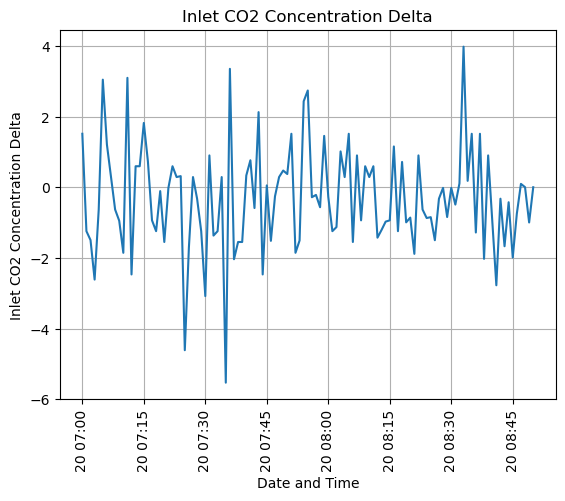

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


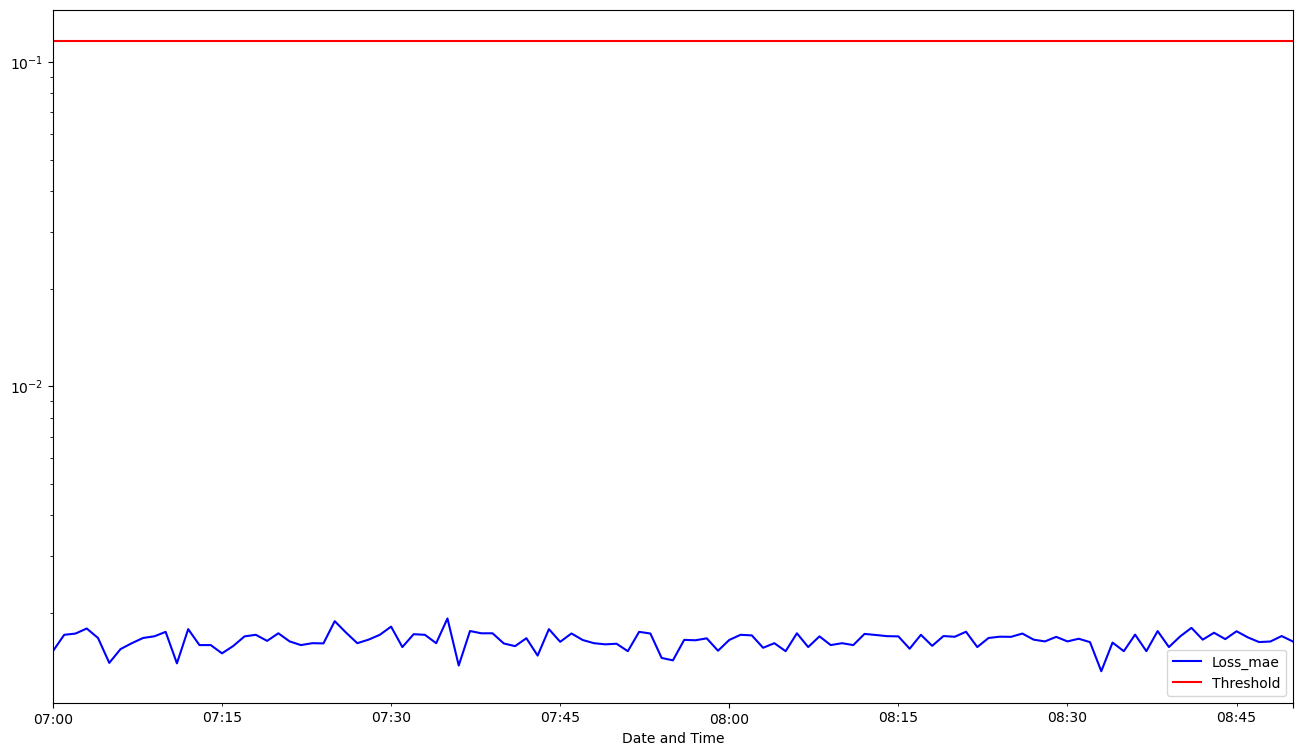

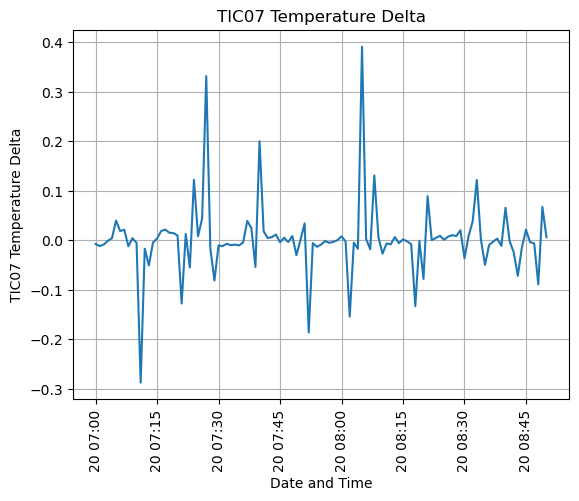

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


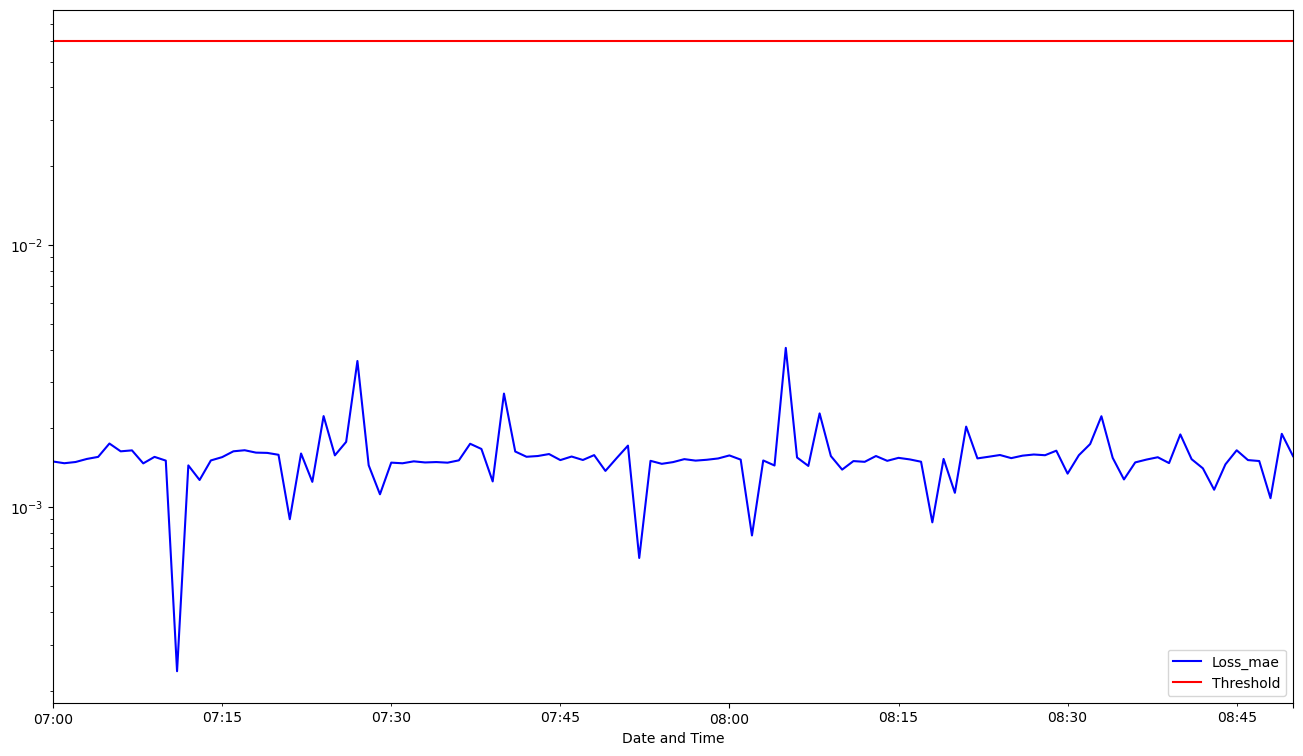

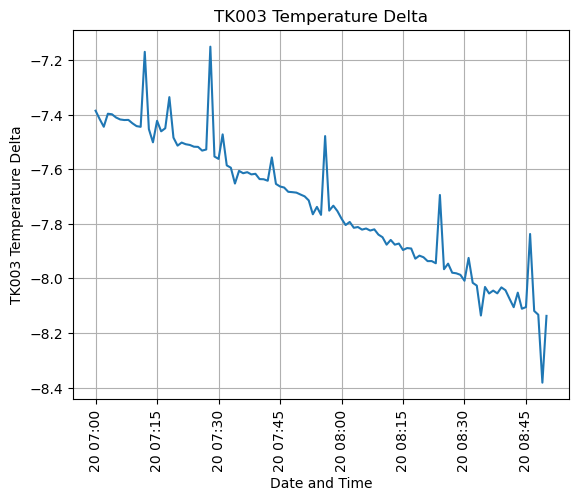

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


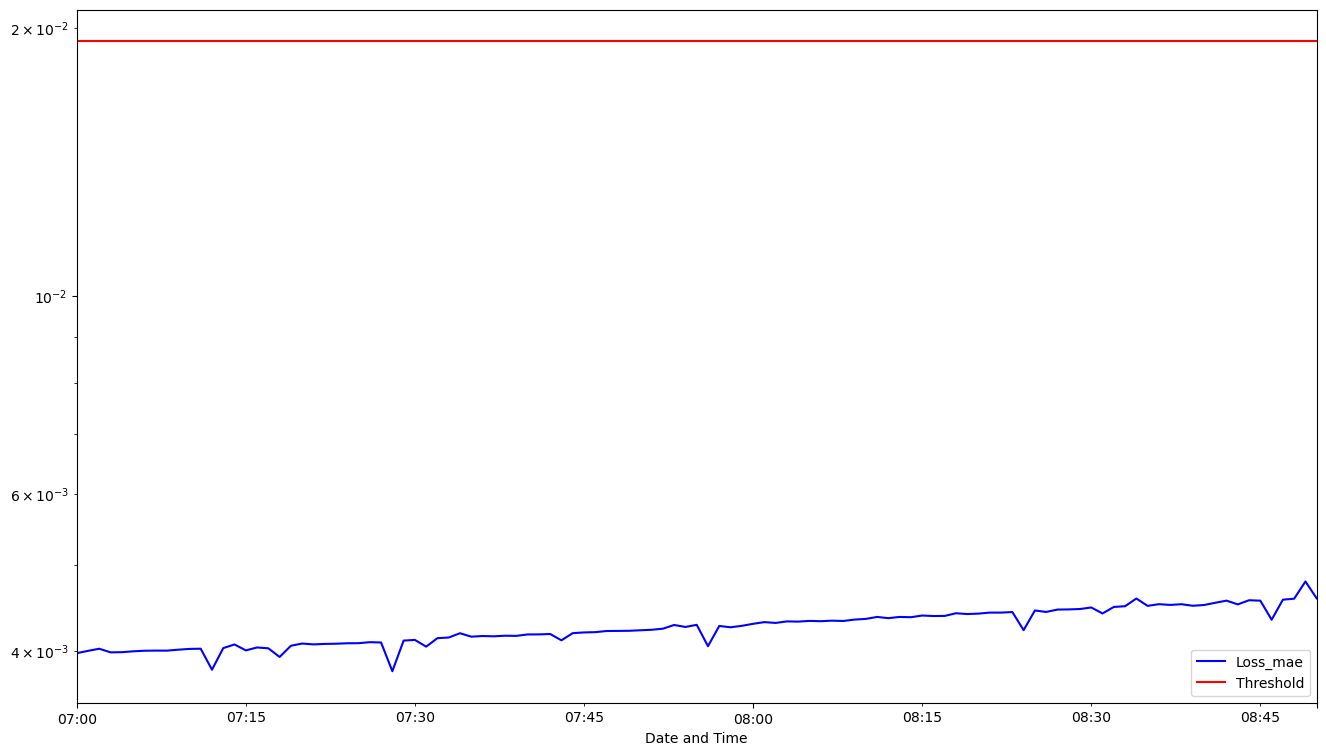

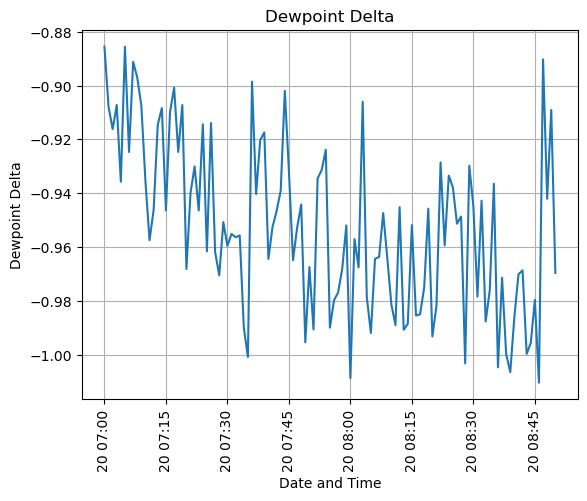

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


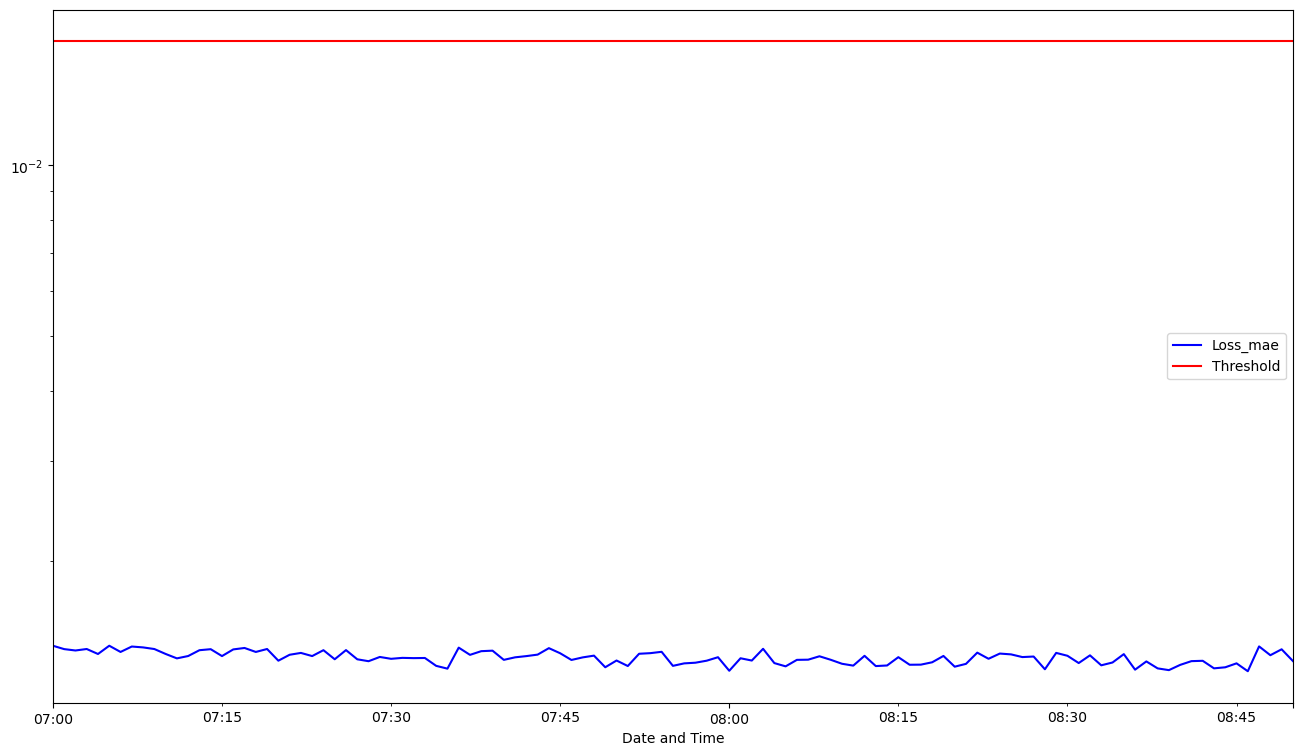

In [349]:
# Apply models for each sensor on recent data
for s in model_dict.keys():
    apply_model(df_test, s)
    
# apply_model(df_test, 'TIC07')

## Development

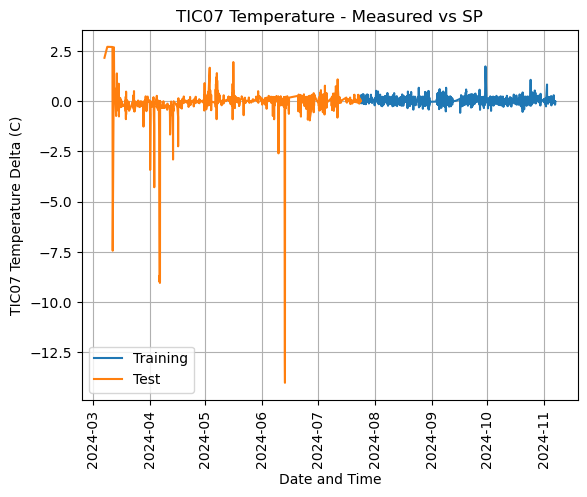

In [6]:
# Set random seed
seed(10)
tf.random.set_seed(10)

# Split into training and test sets
df_train = df_filter.loc[2500:,['Date and Time','TIC07 Temperature Delta']]
df_test = df_filter.loc[:2500,['Date and Time','TIC07 Temperature Delta']]

# Plot training and test data
fig, ax = plt.subplots()
ax.plot(df_train['Date and Time'], df_train['TIC07 Temperature Delta'], label='Training')
ax.plot(df_test['Date and Time'], df_test['TIC07 Temperature Delta'], label='Test')
plt.xticks(rotation=90)
plt.xlabel('Date and Time')
plt.ylabel('TIC07 Temperature Delta (C)')
plt.title('TIC07 Temperature - Measured vs SP')
plt.legend()
ax.set_axisbelow(True)
plt.grid()
plt.show()

In [7]:
# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(df_train.iloc[:,1:2])
X_test = scaler.transform(df_test.iloc[:,1:2])

# Reshape inputs
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 4)                   │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 4)                │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 16)               │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 1)                │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,993 (11.69 KB)

 Trainable params: 2,993 (11.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.1386 - val_loss: 0.0249
Epoch 2/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0295 - val_loss: 0.0207
Epoch 3/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0190 - val_loss: 0.0056
Epoch 4/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 5/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 6/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 8/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 9/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 10/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 11/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 12/100
397/397 ━━━━━━━━━━━━━━━━━━━

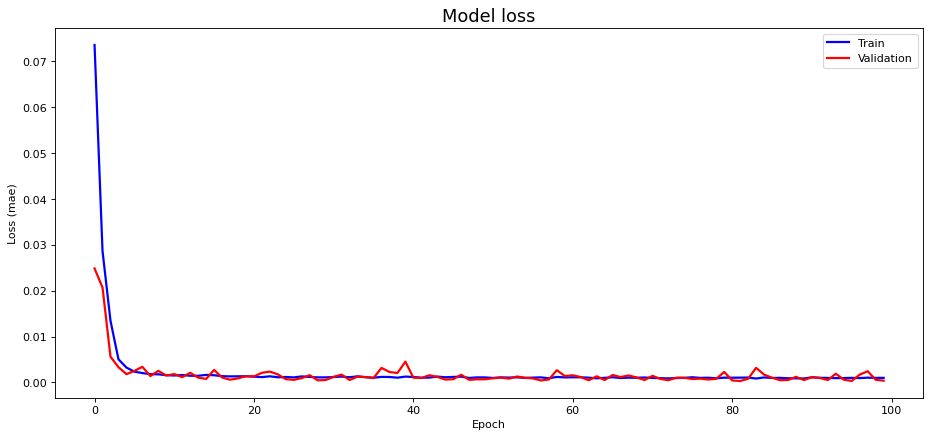

In [8]:
# Create the model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

# Fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

# Plot the training losses
fix, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend()
plt.show()

131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


C:\Users\Daniel Hardiman\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


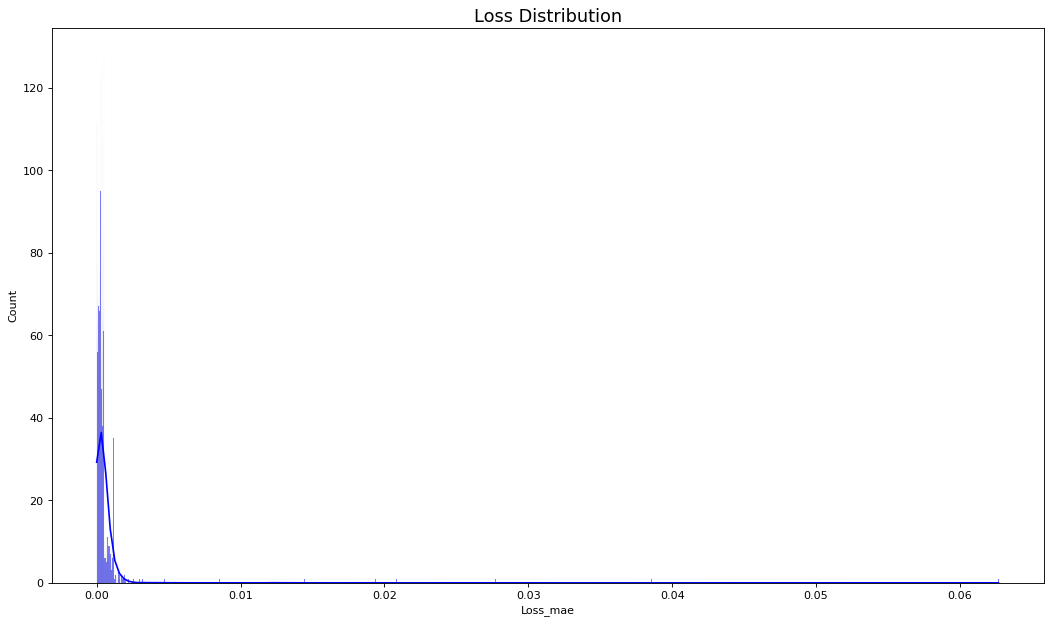

In [9]:
# Distribution of training losses
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns = [df_train.columns[1]])
X_pred_train.index = df_train.index

scored_train = pd.DataFrame(index=df_train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train - Xtrain), axis = 1)

plt.figure(figsize = (16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(scored_train['Loss_mae'], binwidth = 0.00001, kde = True, color = 'blue')
# plt.ylim([0,120])
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Axes: >

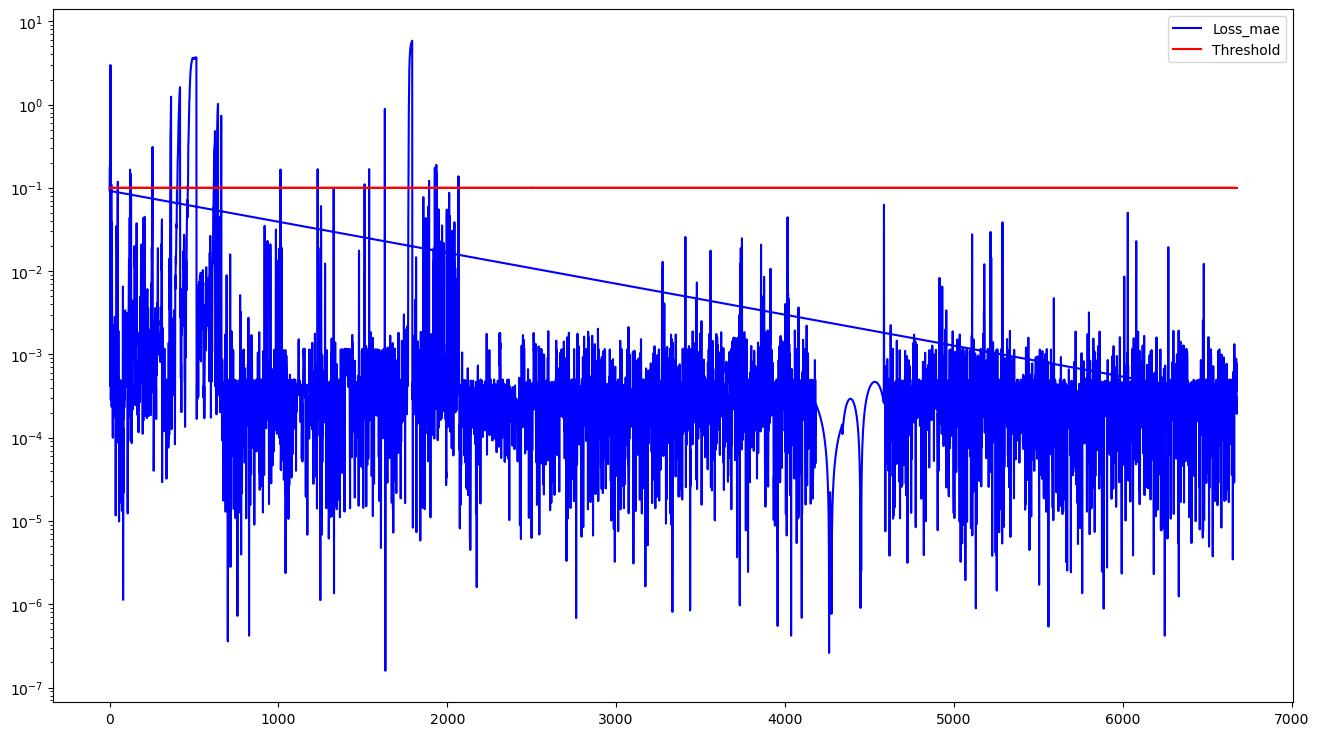

In [10]:
threshold = 0.1 # interlock threshold

# Calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns = [df_test.columns[1]])
X_pred.index = df_test.index

scored = pd.DataFrame(index = df_test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred - Xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']

# Calculate the same metrics on the training set and merge all data in a single df for plotting
scored_train['Threshold'] = threshold
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

# Time plot
scored.plot(logy = True, figsize = (16,9), color = ['blue', 'red'])